# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import plotly.graph_objects as go
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.signal import savgol_filter

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:71% !important; }</style>"))

# Get the Data

In [3]:
bitcoinData = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

In [4]:
bitcoinData

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [5]:
print(bitcoinData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB
None


# Data Processing

In [6]:
pd.isnull(bitcoinData).any()

Timestamp            False
Open                  True
High                  True
Low                   True
Close                 True
Volume_(BTC)          True
Volume_(Currency)     True
Weighted_Price        True
dtype: bool

In [7]:
bitcoinData.dropna(axis=0, how='any', inplace=True)
bitcoinData['Timestamp'] = pd.to_datetime(bitcoinData['Timestamp'],unit='s')
bitcoinData.set_index('Timestamp', inplace=True)
bitcoinData

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


In [8]:
feat = list(bitcoinData.columns)
# target, feat  = feat.pop(), feat
print(feat)

['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']


# Data Resampling

In [9]:
def resampledData(data, timeframe) :
    return data.resample(timeframe, origin='start').agg({'Open': 'first', 'High': 'max','Low': 'min',
     'Close': 'last', 'Volume_(BTC)': 'sum', 'Volume_(Currency)':'sum', 'Weighted_Price': 'mean'})

In [10]:
# bitcoinData.rename(columns={'Volume_(BTC)' : 'Volume'}, inplace=True)

# Studying daily patterns (timeframe = 1 day) 

In [11]:
dayData = resampledData(bitcoinData, '1D')
dayData

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.58,4.39,4.58,96.819878,4.321995e+02,4.493282
2012-01-01 07:52:00,4.84,5.00,4.84,5.00,20.100000,9.890000e+01,4.920000
2012-01-02 07:52:00,5.00,5.00,5.00,5.00,19.048000,9.524000e+01,5.000000
2012-01-03 07:52:00,5.32,5.32,4.93,4.93,100.037281,5.239652e+02,5.188000
2012-01-04 07:52:00,5.19,5.79,5.19,5.79,120.233260,6.529162e+02,5.426046
...,...,...,...,...,...,...,...
2021-03-26 07:52:00,53415.39,55597.04,52489.10,54915.21,4340.604099,2.338751e+08,54094.747873
2021-03-27 07:52:00,54968.90,56686.15,53948.35,56203.95,2366.879294,1.314790e+08,55547.909890
2021-03-28 07:52:00,56188.29,56573.04,54677.51,56020.88,2507.439479,1.392435e+08,55612.621759


## Visualization

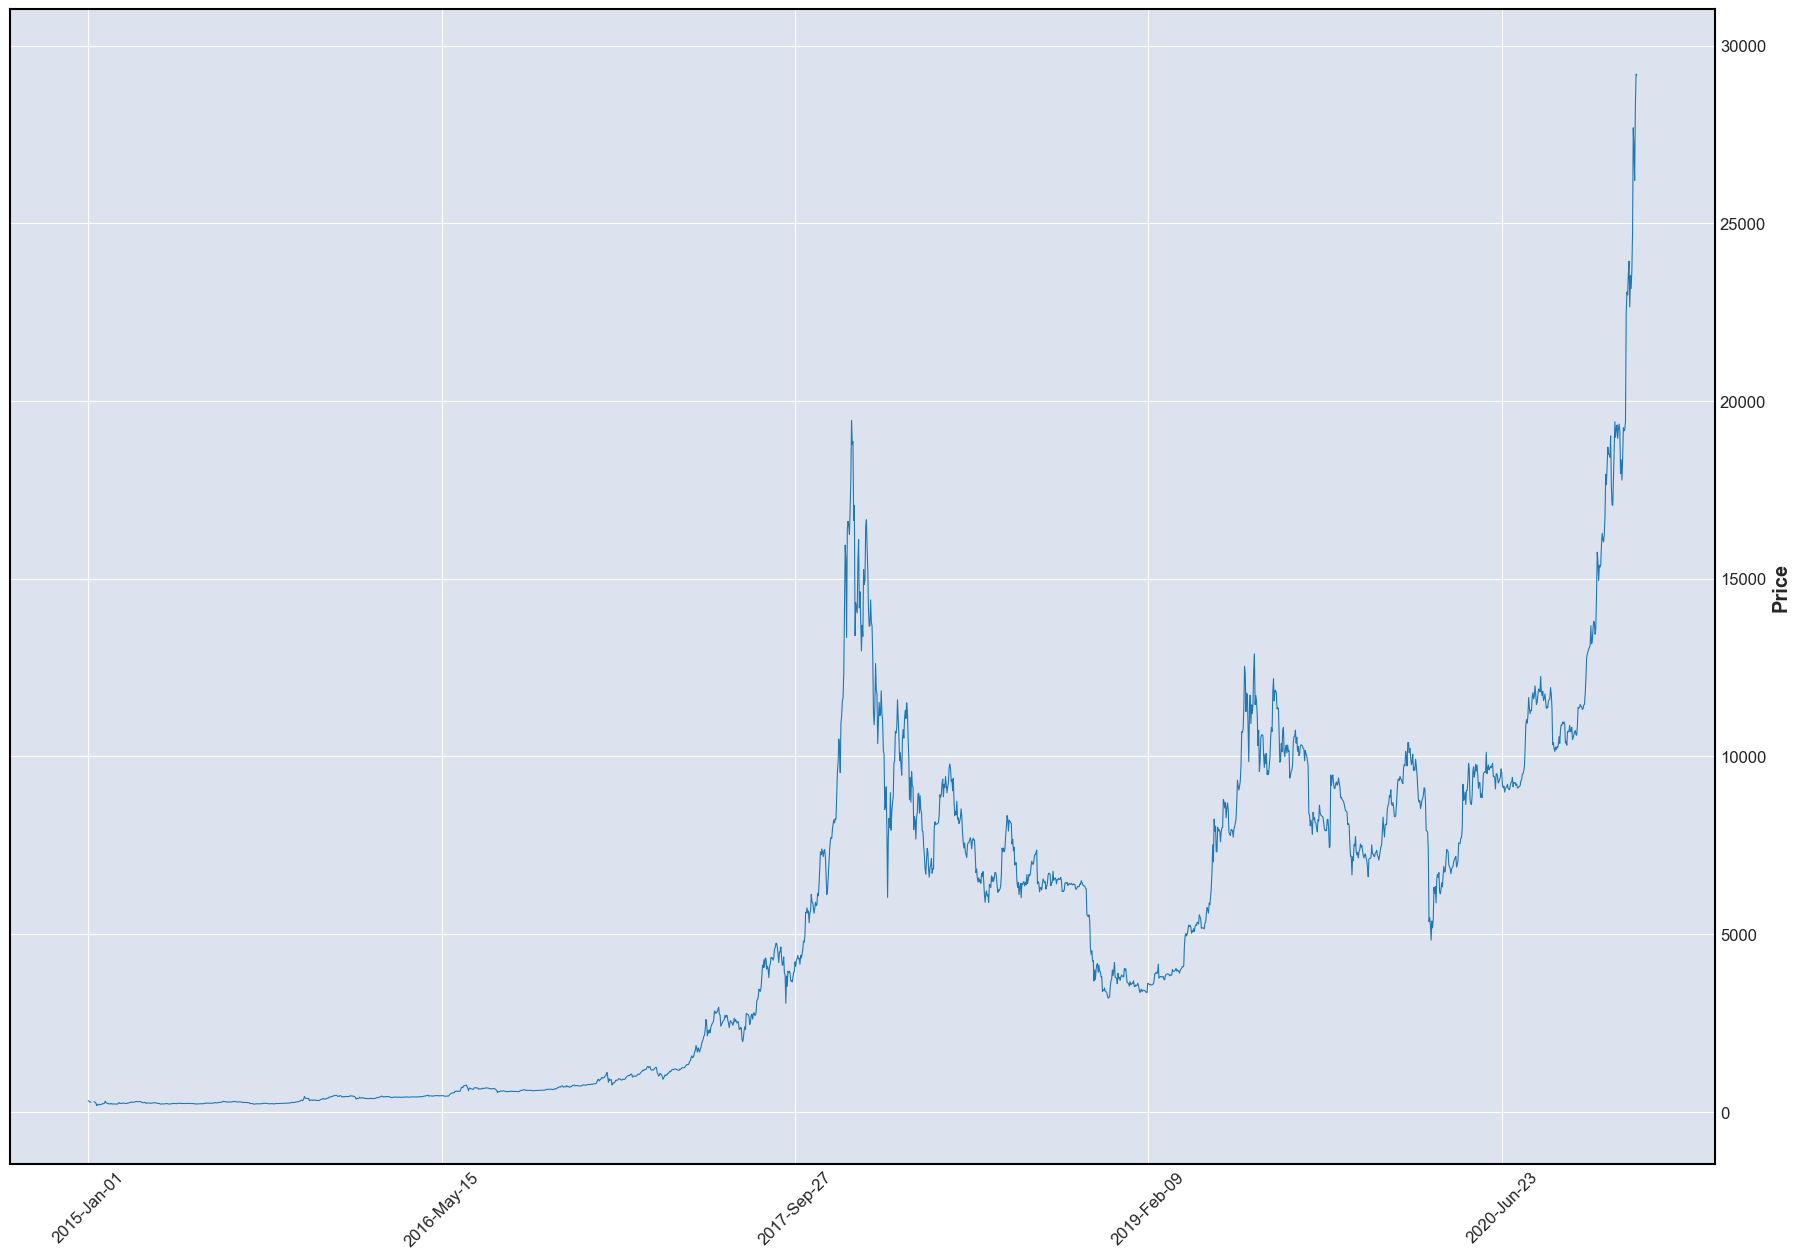

In [12]:
fig = mpf.figure(figsize=(22, 15))
ax = fig.add_subplot(1,1,1)
mask = (dayData.index > '2015-01-01') & (dayData.index < '2021-01-01')
mpf.plot(dayData[mask], type='line', style='yahoo', ax=ax)

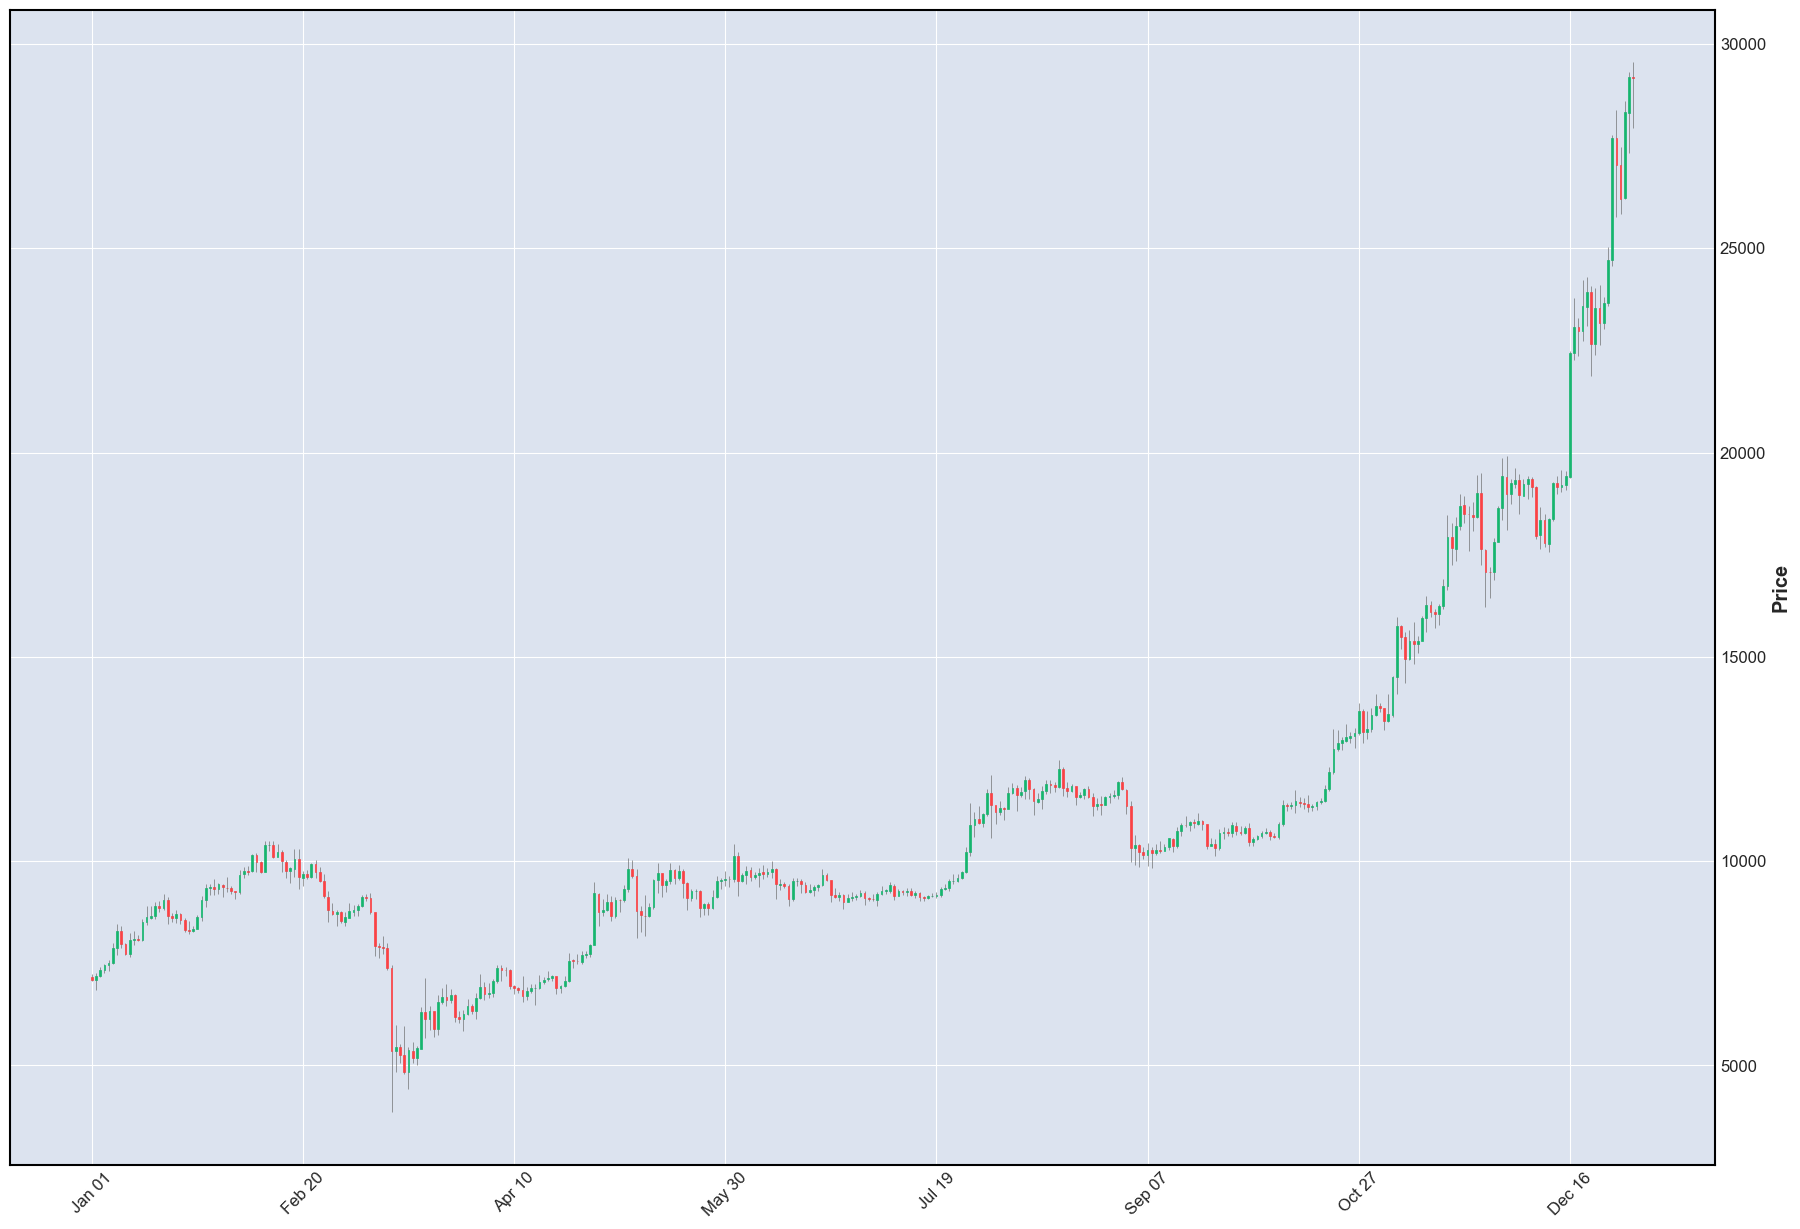

In [13]:
fig = mpf.figure(figsize=(22, 15))
ax = fig.add_subplot(1,1,1)
mask = (dayData.index > '2020-01-01') & (dayData.index < '2021-01-01')
mpf.plot(dayData[mask], type='candle', style='yahoo', ax=ax)

In [14]:
#dayData = dayData[mask]
mask = (dayData.index > '2016-01-01')
figure = go.Figure(
    data = [
        go.Candlestick(x=dayData[mask].index, low=dayData[mask].Low, high=dayData[mask].High, 
                       open=dayData[mask].Open, close=dayData[mask].Close,
                       increasing_line_color = 'green', decreasing_line_color ='red')
    ]
)
#figure.update_layout(xaxis_rangeslider_visible=False)

## Regression

In [15]:
feat = list(dayData.columns)

In [16]:
testNull = pd.isnull(dayData).values
print(np.count_nonzero(testNull))
dayData = dayData.interpolate()
np.count_nonzero(pd.isnull(dayData).values)

15


0

In [17]:
target, feat = feat[-1], feat[:-2]
print(feat, target)
features = pd.DataFrame(data=dayData, columns=feat) 
features

['Open', 'High', 'Low', 'Close', 'Volume_(BTC)'] Weighted_Price


,Open,High,Low,Close,Volume_(BTC)
Timestamp,,,,,
2011-12-31 07:52:00,4.39,4.58,4.39,4.58,96.819878
2012-01-01 07:52:00,4.84,5.00,4.84,5.00,20.100000
2012-01-02 07:52:00,5.00,5.00,5.00,5.00,19.048000
2012-01-03 07:52:00,5.32,5.32,4.93,4.93,100.037281
2012-01-04 07:52:00,5.19,5.79,5.19,5.79,120.233260
...,...,...,...,...,...
2021-03-26 07:52:00,53415.39,55597.04,52489.10,54915.21,4340.604099
2021-03-27 07:52:00,54968.90,56686.15,53948.35,56203.95,2366.879294
2021-03-28 07:52:00,56188.29,56573.04,54677.51,56020.88,2507.439479


In [18]:
price = dayData['Weighted_Price']
newPrice = price.tail(price.shape[0]-1)
newFeatures = features.head(features.shape[0]-1)
newFeatures.index = newFeatures.index + pd.DateOffset(days=1)
# newPrice, newFeatures

In [19]:
xTrain, xTest, yTrain, yTest = train_test_split(newFeatures, newPrice, test_size=.4, random_state=10)
regr =  LinearRegression().fit(xTrain,yTrain)
regr.intercept_, regr.coef_

(-5.613768909413011,
 array([4.44650967e-03, 7.63265140e-02, 5.87381795e-02, 8.61941741e-01,
        4.14480053e-04]))

In [20]:
print('R² Training Data: ', regr.score(xTrain,yTrain))
print('R² Test Data: ', regr.score(xTest,yTest))

R² Training Data:  0.9990801598216904
R² Test Data:  0.9985813180492884


## P-values

In [21]:
xAndConst = sm.add_constant(xTrain)
model = sm.OLS(yTrain, xAndConst)
results = model.fit()
pandaPvalues = pd.DataFrame({'coef':results.params, 'p-values':round(results.pvalues,4)})
pandaPvalues.sort_values(by='p-values')

,coef,p-values
Close,0.861942,0.0000
High,0.076327,0.0127
Low,0.058738,0.0237
Volume_(BTC),0.000414,0.4591
const,-5.613769,0.5191
Open,0.004447,0.8549


In [22]:
print('Bic :', results.bic)
print('MSE :', results.mse_resid)

Bic : 28102.17581908225
MSE : 60676.298223031576


In [23]:
#plt.scatter(results.fittedvalues, results.resid ,c='darkred', alpha = .4)

### Enhancing model

In [24]:
xAndConst = xAndConst.drop(['Open','const','Volume_(BTC)'], axis=1) 

In [25]:
model = sm.OLS(yTrain, xAndConst)
results = model.fit()
pandaPvalues = pd.DataFrame({'coef':results.params, 'p-values':round(results.pvalues,4)})
pandaPvalues.sort_values(by='p-values')

,coef,p-values
Close,0.858385,0.0000
High,0.084442,0.0001
Low,0.058240,0.0011


In [26]:
print('Bic :', results.bic)
print('R-squared :', results.rsquared)
print('MSE :', results.mse_resid)

Bic : 28079.95846357154
R-squared : 0.9993031046752742
MSE : 60604.984770481955


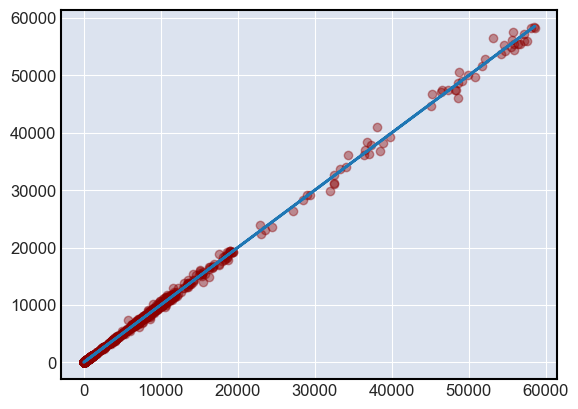

In [27]:
plt.plot(yTrain,yTrain)
plt.scatter(yTrain,results.fittedvalues, c='darkred', alpha = .4)

In [28]:
#plt.scatter(results.fittedvalues, results.resid ,c='darkred', alpha = .4)

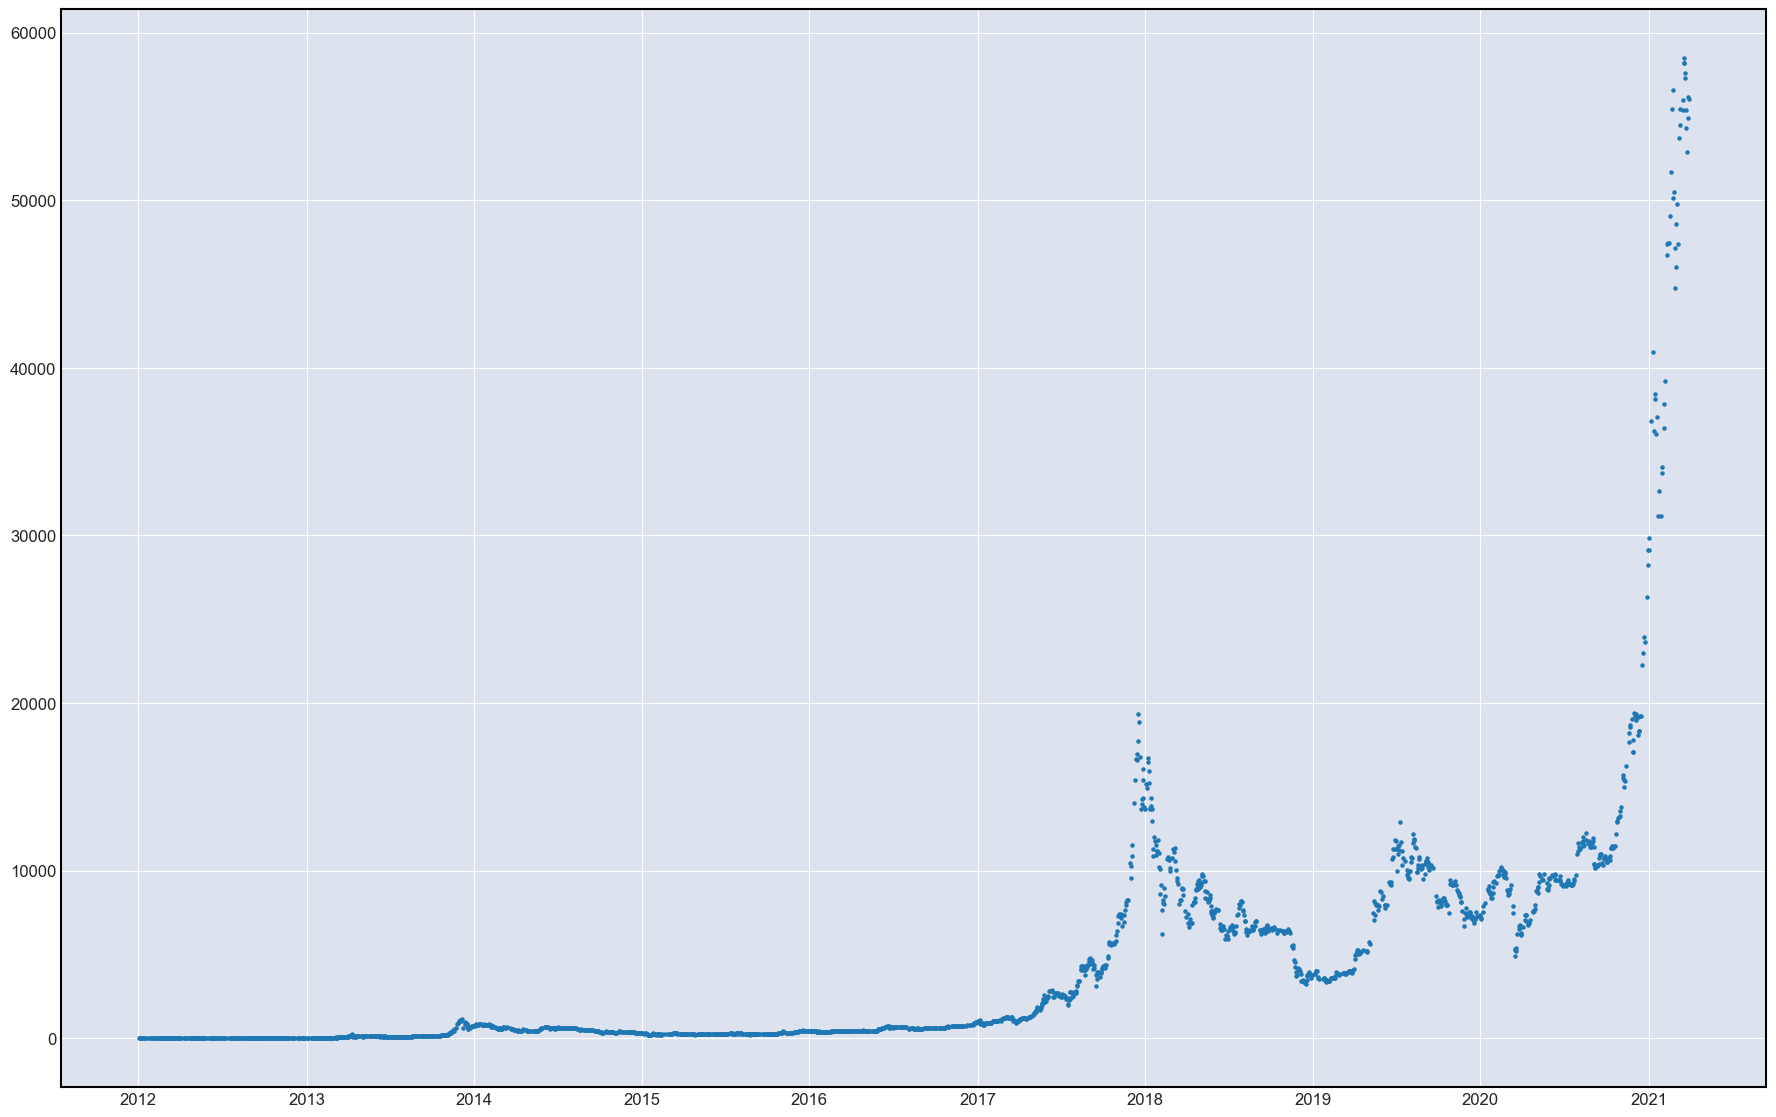

In [29]:
plt.figure(figsize=(22,14))
plt.scatter(yTrain.index,results.fittedvalues, s=5)

## Prediction & Visualization 

In [30]:

# xTrain0, xTest0, yTrain0, yTest0 = train_test_split(newFeatures, newPrice, test_size=.4, random_state=10)
# regr0 =  LinearRegression().fit(xTrain0,yTrain0)

xTrain, xTest, yTrain, yTest = train_test_split(newFeatures.drop(['Open'],axis=1), newPrice, test_size=.4, random_state=10)
regr =  LinearRegression().fit(xTrain,yTrain)
regr.intercept_, regr.coef_

(-5.603860231407452,
 array([8.02375624e-02, 6.20735638e-02, 8.59120996e-01, 4.17492388e-04]))

In [31]:
print('R² Training Data: ', regr.score(xTrain,yTrain))
print('R² Test Data: ', regr.score(xTest,yTest))

# With intercept
# R² Training Data:  0.9990799558723433
# R² Test Data:  0.9985792560358903

R² Training Data:  0.9990801445918173
R² Test Data:  0.9985810318202238


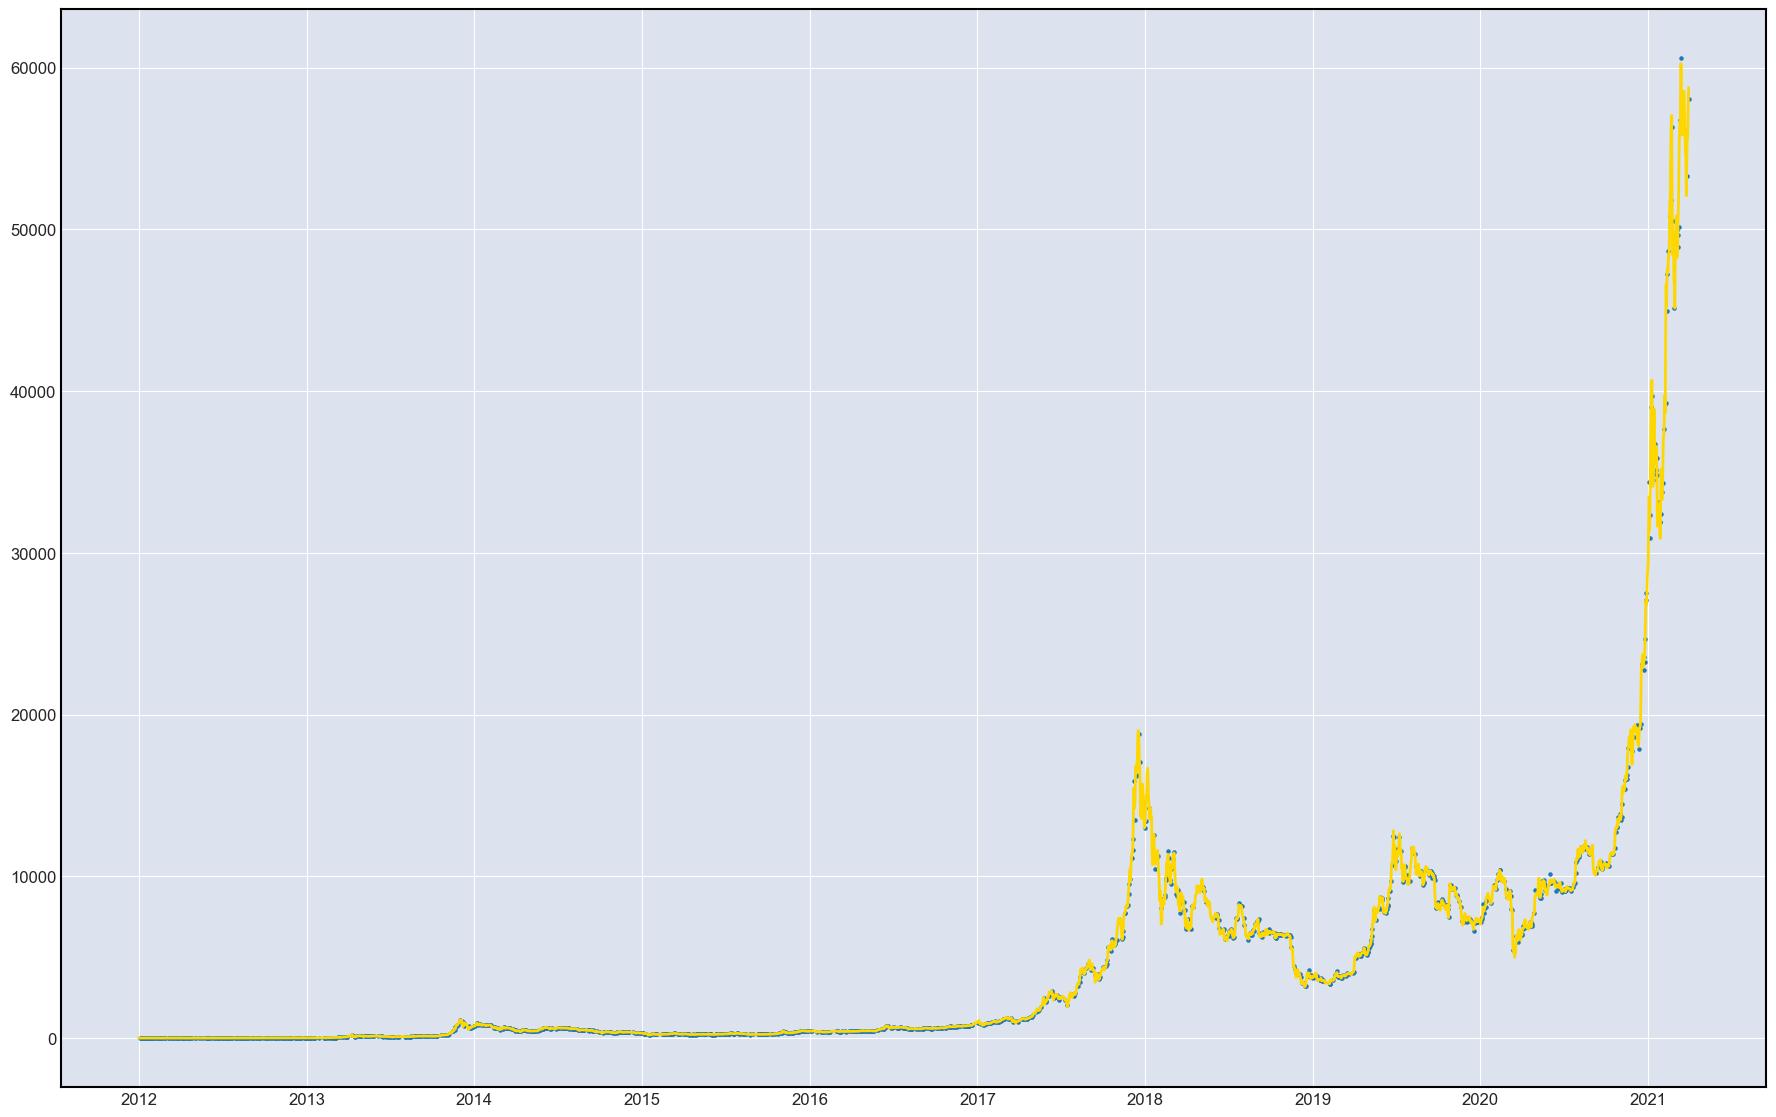

In [32]:
plt.figure(figsize=(22,14))
plt.plot(dayData.index,dayData.Weighted_Price, color='gold')
plt.scatter(xTest.index, regr.predict(xTest), s=5)
# plt.scatter(xTest.index, regr0.predict(xTest0), s=5, color='red')


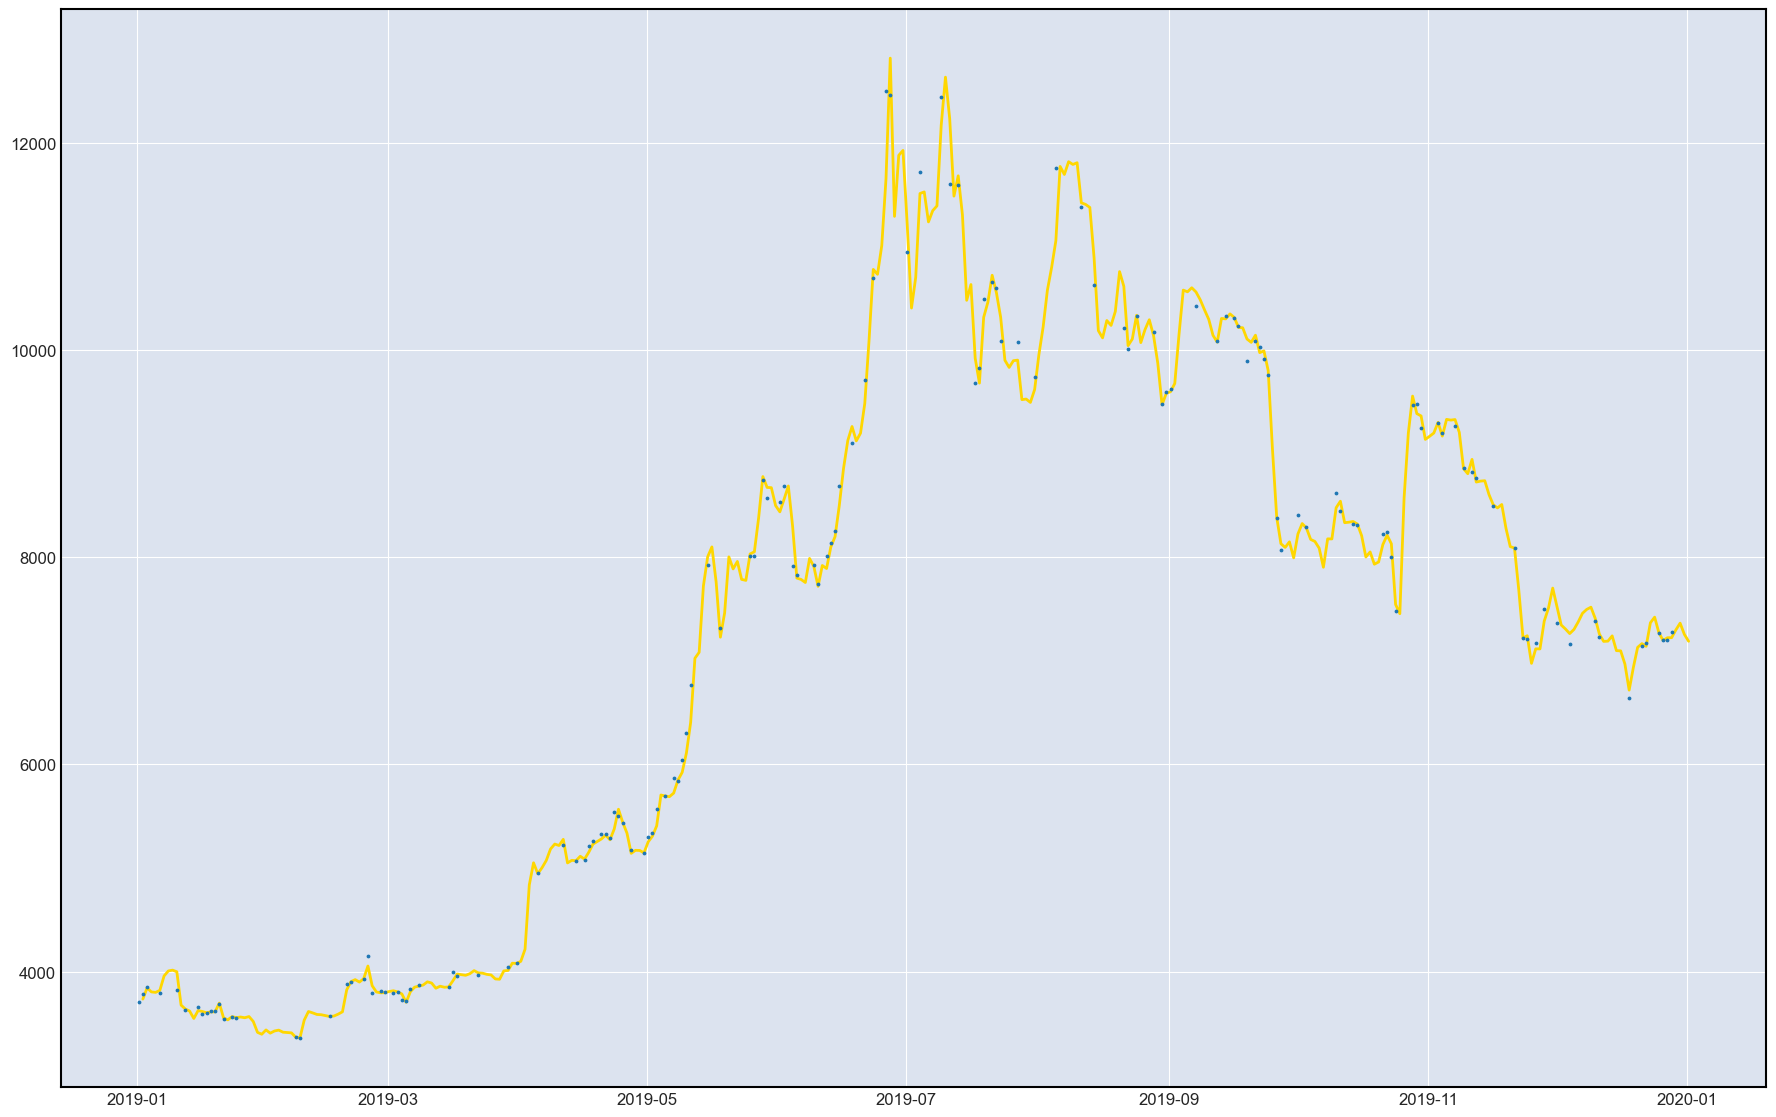

In [33]:
plt.figure(figsize=(22,14))
maskData = (dayData.index > '2019') & (dayData.index < '2020')
maskPrediction = (xTest.index > '2019') & (xTest.index < '2020')

plt.plot(dayData.index[maskData] + pd.DateOffset(days=1) ,dayData.Weighted_Price[maskData], color='gold')
# plt.scatter(xTest.index.sort_values(), regr.predict(xTest.sort_index(axis=0)), s=3)
plt.scatter(xTest.index[maskPrediction], regr.predict(xTest[maskPrediction]), s=3, zorder=4)

#plt.scatter(xTest0.index[maskPrediction], regr0.predict(xTest0[maskPrediction]), s=3, zorder=3)

# Studying weekly patterns (timeframe = 1 Week)

In [34]:
week = resampledData(bitcoinData, '7D')

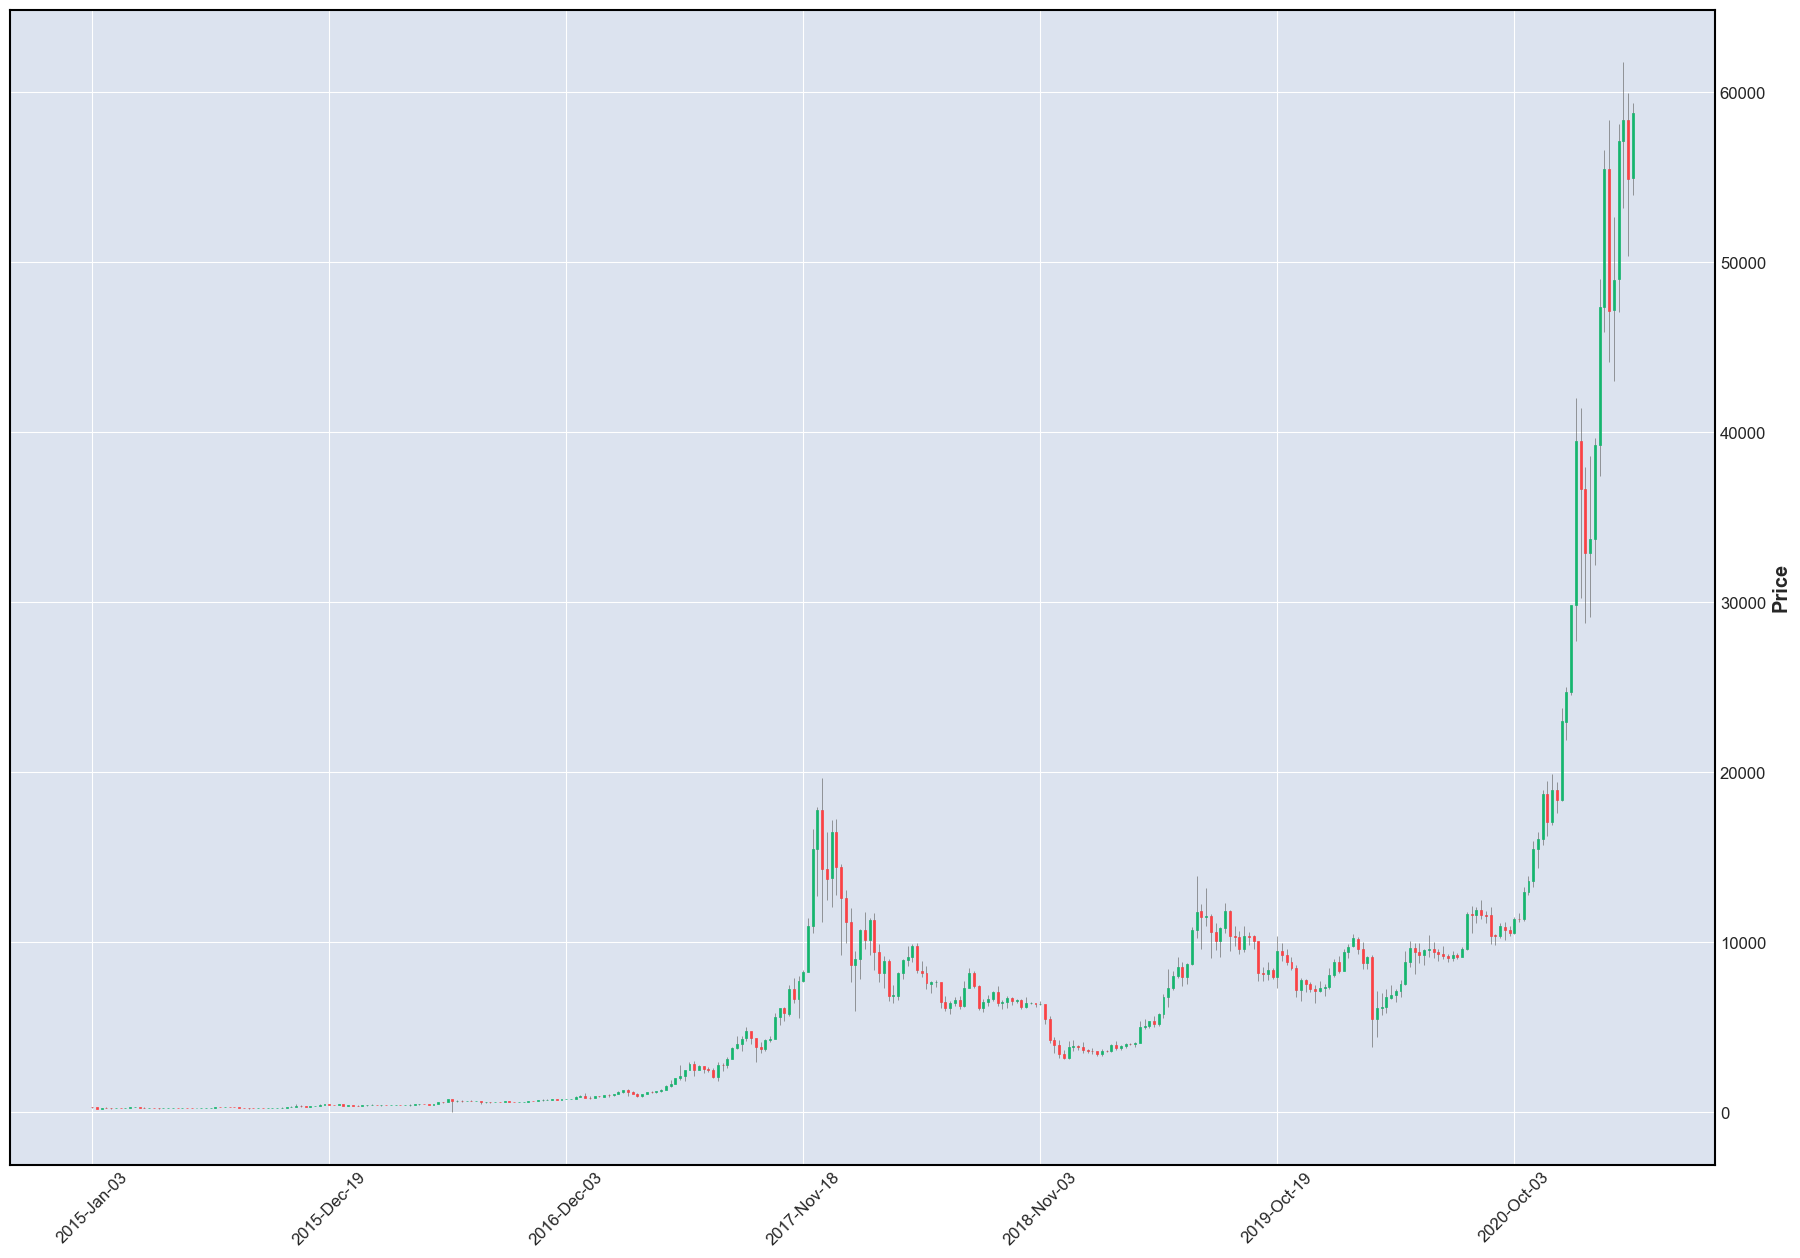

In [35]:
fig = mpf.figure(figsize=(22, 15))
ax = fig.add_subplot(1,1,1)
mask = (week.index > '2015')
mpf.plot(week[mask], type='candle', style='yahoo', ax=ax)

In [36]:
# print(pd.isnull(week).any())
#week = week[mask]
weekFeatures = pd.DataFrame(data=week, columns=feat)
weekFeatures = weekFeatures.head(weekFeatures.shape[0]-1)
weekPrice = week['Weighted_Price'].tail(week.shape[0]-1)
weekFeatures.index = weekFeatures.index + pd.DateOffset(days=7)
weekFeatures

,Open,High,Low,Close,Volume_(BTC)
Timestamp,,,,,
2012-01-07 07:52:00,4.39,6.90,4.39,6.00,459.922995
2012-01-14 07:52:00,6.80,7.38,6.23,6.40,383.685872
2012-01-21 07:52:00,6.30,7.15,5.52,6.95,590.087191
2012-01-28 07:52:00,6.30,6.86,3.80,4.91,546.424076
2012-02-04 07:52:00,5.89,6.37,3.80,5.95,562.033492
...,...,...,...,...,...
2021-02-27 07:52:00,55492.86,58354.14,44151.97,47159.64,68062.762239
2021-03-06 07:52:00,47176.15,52652.82,43021.00,48972.13,39847.298375
2021-03-13 07:52:00,48992.61,58155.99,47082.29,57165.54,33412.876903


In [37]:
#weekPrice = savgol_filter(weekPrice, 52, 5)

## Random State Finder 

In [38]:
def bestRandomState(a, b, features, target, removedFeatures=[], intercept=True) :
    valuesDict = {'bic':[], 'mse':[], 'rsq':[], 'avgRsq':[]}
    bic, mse, rsq, avgRsq = [], [], [], []
    features = features.drop(removedFeatures, axis=1)
    for i in range(a,b) :
        xTrain, xTest, yTrain, yTest = train_test_split(features, target, test_size=.4, random_state=i)
        regr =  LinearRegression(fit_intercept=intercept).fit(xTrain,yTrain)
        xAndConst = sm.add_constant(xTrain)
        if intercept == False:
            xAndConst = xAndConst.drop(['const'], axis=1)
        model = sm.OLS(yTrain, xAndConst)
        results = model.fit()
        bic.append(results.bic)
        rsq.append(regr.score(xTest,yTest))
        mse.append(results.mse_resid)
        avgScore = (regr.score(xTest,yTest)+regr.score(xTrain,yTrain))/2
        avgRsq.append(avgScore)
        if results.bic == min(bic) : 
            valuesDict['bic'] = [min(bic),i]
        if results.mse_resid == min(mse) : 
            valuesDict['mse'] = [min(mse),i]
        if regr.score(xTest,yTest) == max(rsq) : 
            valuesDict['rsq'] = [max(rsq),i]
        if avgScore == max(avgRsq) : 
            valuesDict['avgRsq'] = [max(avgRsq),i]

    return valuesDict

In [39]:
def bestRandomState2(a, b, features, target, removedFeatures=[], intercept=True) :
    valuesDict = {'bic':[], 'mse':[], 'rsq':[]}
    bic, mse, rsq = [], [], []
    features = features.drop(removedFeatures, axis=1)
    for i in range(a,b) :
        for j in range(21) :
            xTrain, xTest, yTrain, yTest = train_test_split(features, target, test_size=.3+.01*j, random_state=i)
            regr =  LinearRegression(fit_intercept=intercept).fit(xTrain,yTrain)
            xAndConst = sm.add_constant(xTrain)
            if intercept == False :
                xAndConst = xAndConst.drop(['const'], axis=1)
            model = sm.OLS(yTrain, xAndConst)
            results = model.fit()
            bic.append(results.bic)
            rsq.append(regr.score(xTest,yTest))
            mse.append(results.mse_resid)
            
            if results.bic == min(bic) : 
                valuesDict['bic'] = [min(bic),i,j]
            if regr.score(xTest,yTest) == max(rsq) : 
                valuesDict['rsq'] = [max(rsq),i,j]
            if results.mse_resid == min(mse) : 
                valuesDict['mse'] = [min(mse),i,j]
            
    return valuesDict

## Regression

In [40]:
xTrain, xTest, yTrain, yTest = train_test_split(weekFeatures, weekPrice, test_size=.4, random_state=370)
regr =  LinearRegression().fit(xTrain,yTrain)
print('R² Training Data: ', regr.score(xTrain,yTrain))
print('R² Test Data: ', regr.score(xTest,yTest))

R² Training Data:  0.9933944173924653
R² Test Data:  0.9982912378992915


In [41]:
"""
{'bic': [4144.792903981974, 2240],
 'mse': [89976.5721431261, 2240],
 'rsq': [0.9982912378992915, 370],
 'avgRsq': [0.9959495009323898, 2471]}
"""
#bestRandomState(0,5000, weekFeatures, weekPrice, intercept=False)

"\n{'bic': [4144.792903981974, 2240],\n 'mse': [89976.5721431261, 2240],\n 'rsq': [0.9982912378992915, 370],\n 'avgRsq': [0.9959495009323898, 2471]}\n"

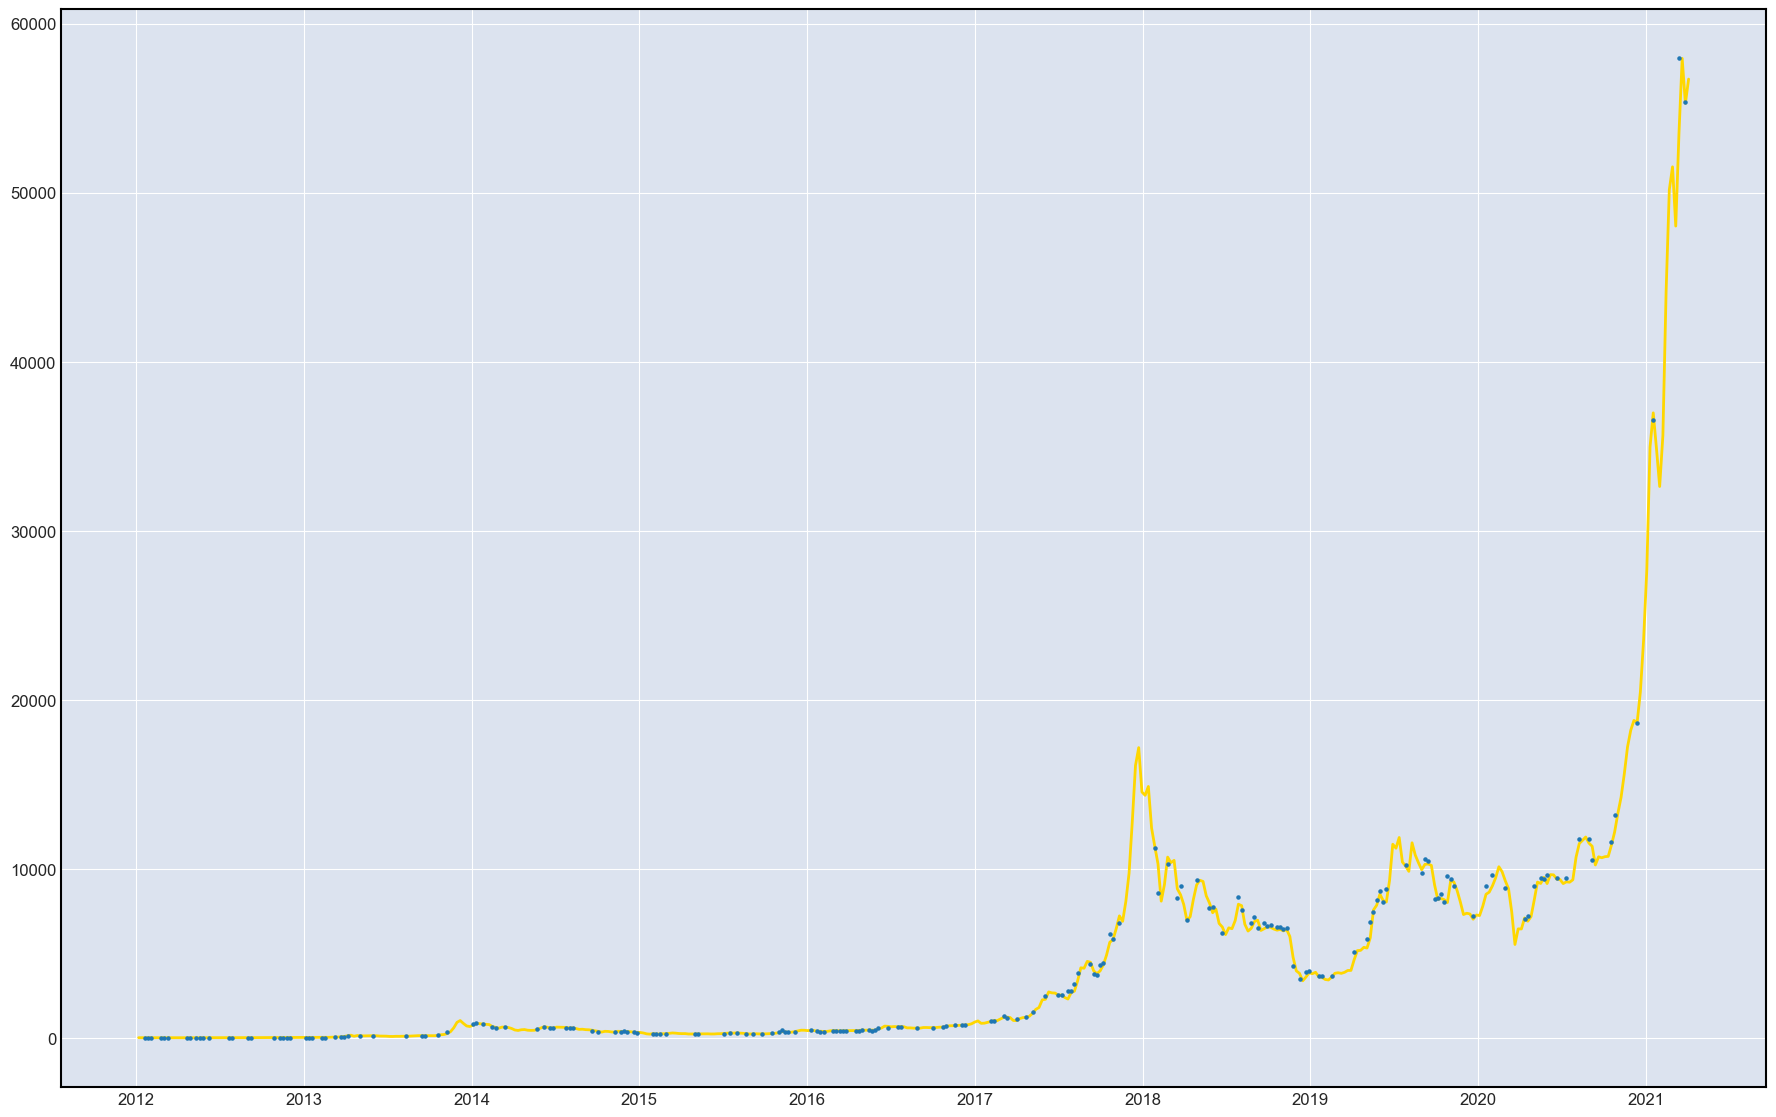

In [42]:
plt.figure(figsize=(22,14))
plt.plot(week.index + pd.DateOffset(days=7),week.Weighted_Price, color='gold')
plt.scatter(xTest.index, regr.predict(xTest), s=5 , zorder=3)

## P-values

In [43]:
xAndConst = sm.add_constant(xTrain)
model = sm.OLS(yTrain, xAndConst)
results = model.fit()
pandaPvalues = pd.DataFrame({'coef':results.params, 'p-values':round(results.pvalues,4)})
pandaPvalues.sort_values(by='p-values')

,coef,p-values
Close,0.947120,0.0000
Low,0.137081,0.2165
Open,-0.102832,0.3166
High,0.041506,0.7417
const,-24.680004,0.7591
Volume_(BTC),0.000191,0.8198


In [44]:
print('Bic :', results.bic)
print('RMSE :', np.sqrt(results.mse_resid))

Bic : 4666.561882457907
RMSE : 739.7903228780837


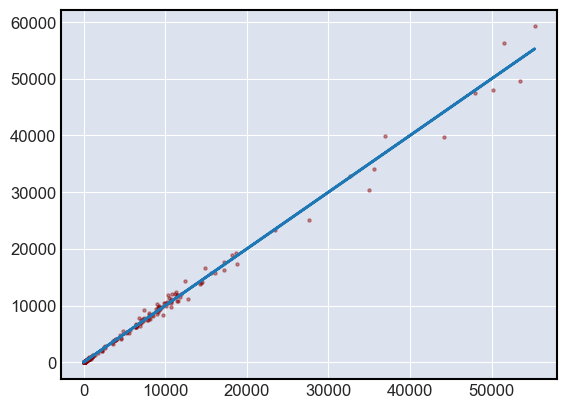

In [45]:
plt.plot(yTrain,yTrain)
plt.scatter(yTrain,results.fittedvalues, c='darkred', alpha = .4, s=5)

In [46]:
xAndConst.drop(['Volume_(BTC)','High'], axis=1, inplace=True) 
model = sm.OLS(yTrain, xAndConst)
results = model.fit()
pandaPvalues = pd.DataFrame({'coef':results.params, 'p-values':round(results.pvalues,4)})
pandaPvalues.sort_values(by='p-values')

,coef,p-values
Close,0.986354,0.0000
Open,-0.070295,0.1511
Low,0.107528,0.1964
const,-11.547672,0.8182


In [47]:
print('Bic :', results.bic)
print('RMSE :', np.sqrt(results.mse_resid))
print('Rsquared : ', results.rsquared)
#,'High','Low','Open'

Bic : 4655.406986700027
RMSE : 737.4170021518603
Rsquared :  0.9933903486182571


In [48]:
#.drop(['Volume_(BTC)','High'], axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(weekFeatures,
                                                 weekPrice, test_size=.4, random_state=370)
regr =  LinearRegression().fit(xTrain,yTrain)
print('R² Training Data: ', regr.score(xTrain,yTrain))
print('R² Test Data: ', regr.score(xTest,yTest))

R² Training Data:  0.9933944173924653
R² Test Data:  0.9982912378992915


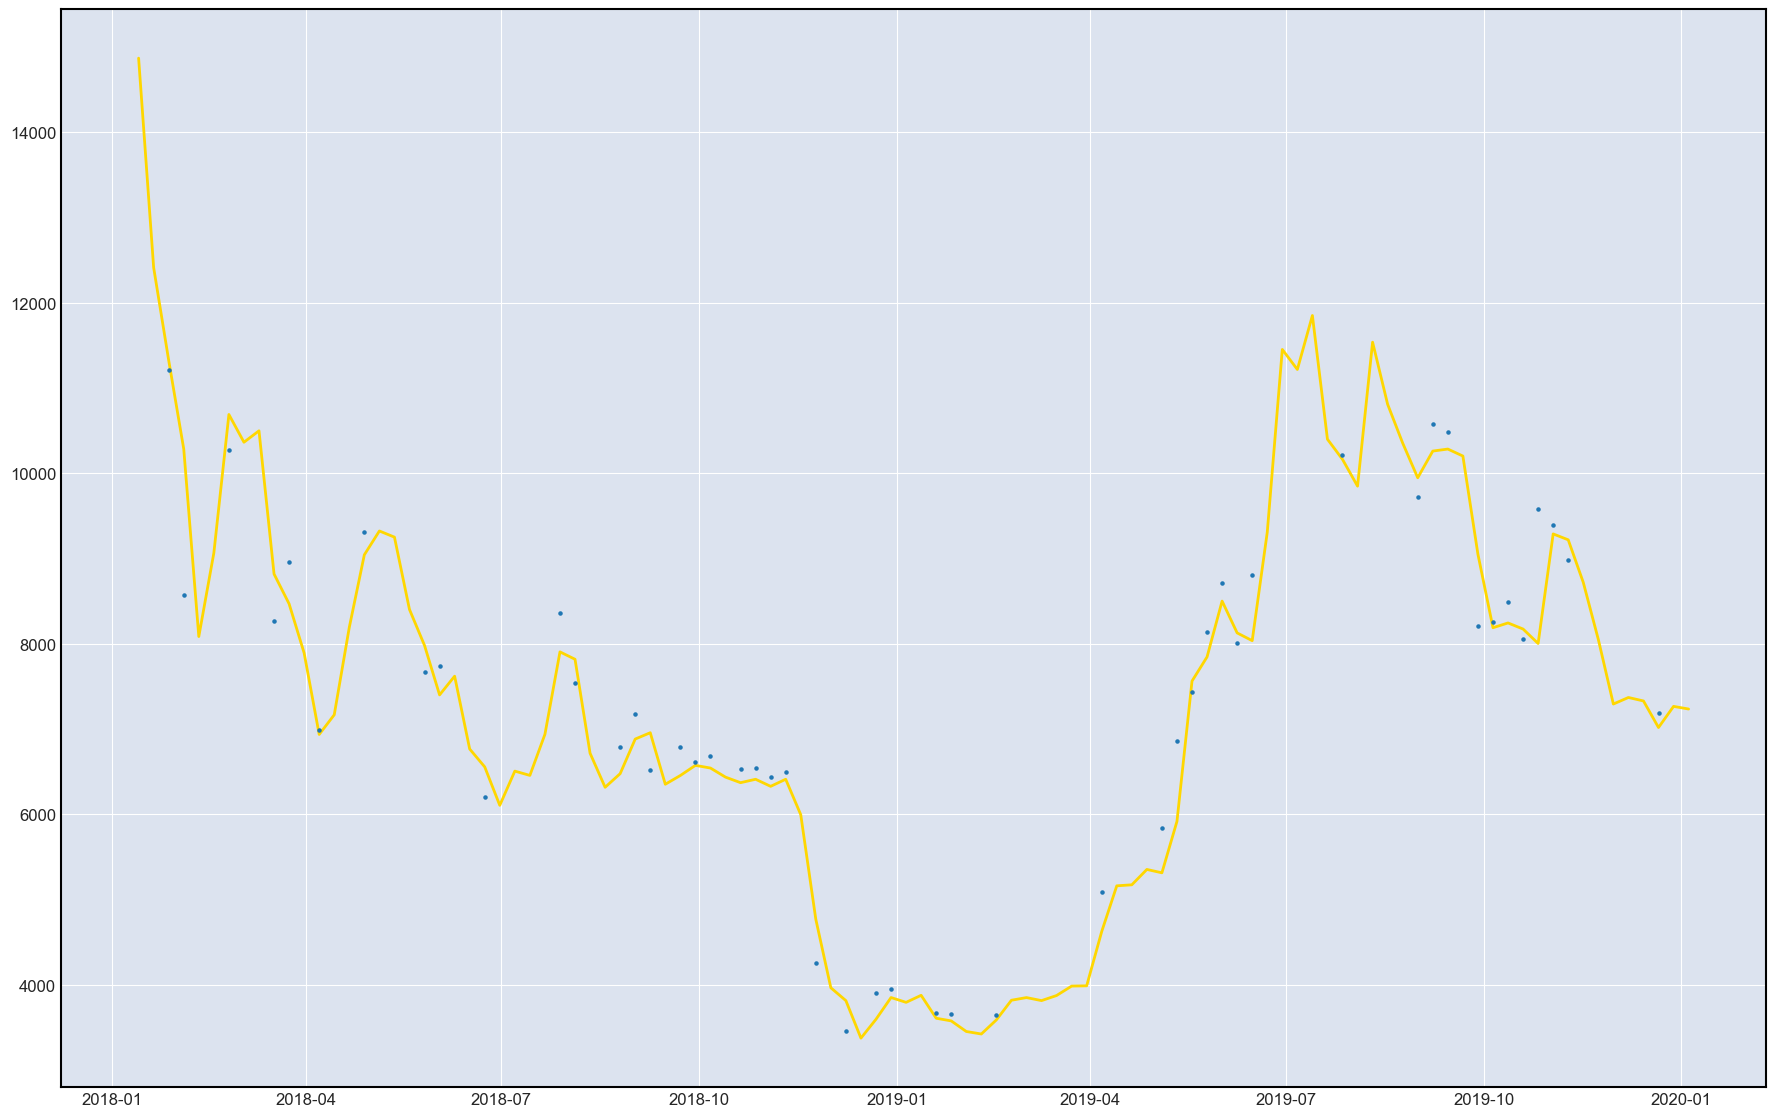

In [49]:
maskData = (week.index > '2018') & (week.index < '2020')
maskPrediction = (xTest.index > '2018') & (xTest.index < '2020')

plt.figure(figsize=(22,14))
plt.plot(week[maskData].index + pd.DateOffset(days=7) ,week[maskData].Weighted_Price, color='gold')
plt.scatter(xTest[maskPrediction].index, regr.predict(xTest[maskPrediction]), s=5, zorder=3)

In [50]:
xAndConst = sm.add_constant(xTrain)
model = sm.OLS(yTrain, xAndConst)
results = model.fit()

In [51]:
print('Bic :', results.bic)
print('MSE :', results.mse_resid)
print('Rsquared : ', results.rsquared)

Bic : 4666.561882457907
MSE : 547289.7218240593
Rsquared :  0.9933944173924653


## Studying weekly model with minimal MSE and BIC

In [52]:
# mask = (weekFeatures.index > '2016')
# weekFeatures = weekFeatures[mask]
# weekPrice = weekPrice[mask]

In [53]:
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(weekFeatures, weekPrice, test_size=.4, random_state=2240)
regr2 =  LinearRegression().fit(xTrain2,yTrain2)
print('R² Training Data: ', regr2.score(xTrain2,yTrain2))
print('R² Test Data: ', regr2.score(xTest2,yTest2))
# R² Training Data:  0.9666389147888864
# R² Test Data:  0.9730157584437494

R² Training Data:  0.9973131313103146
R² Test Data:  0.9932113606309666


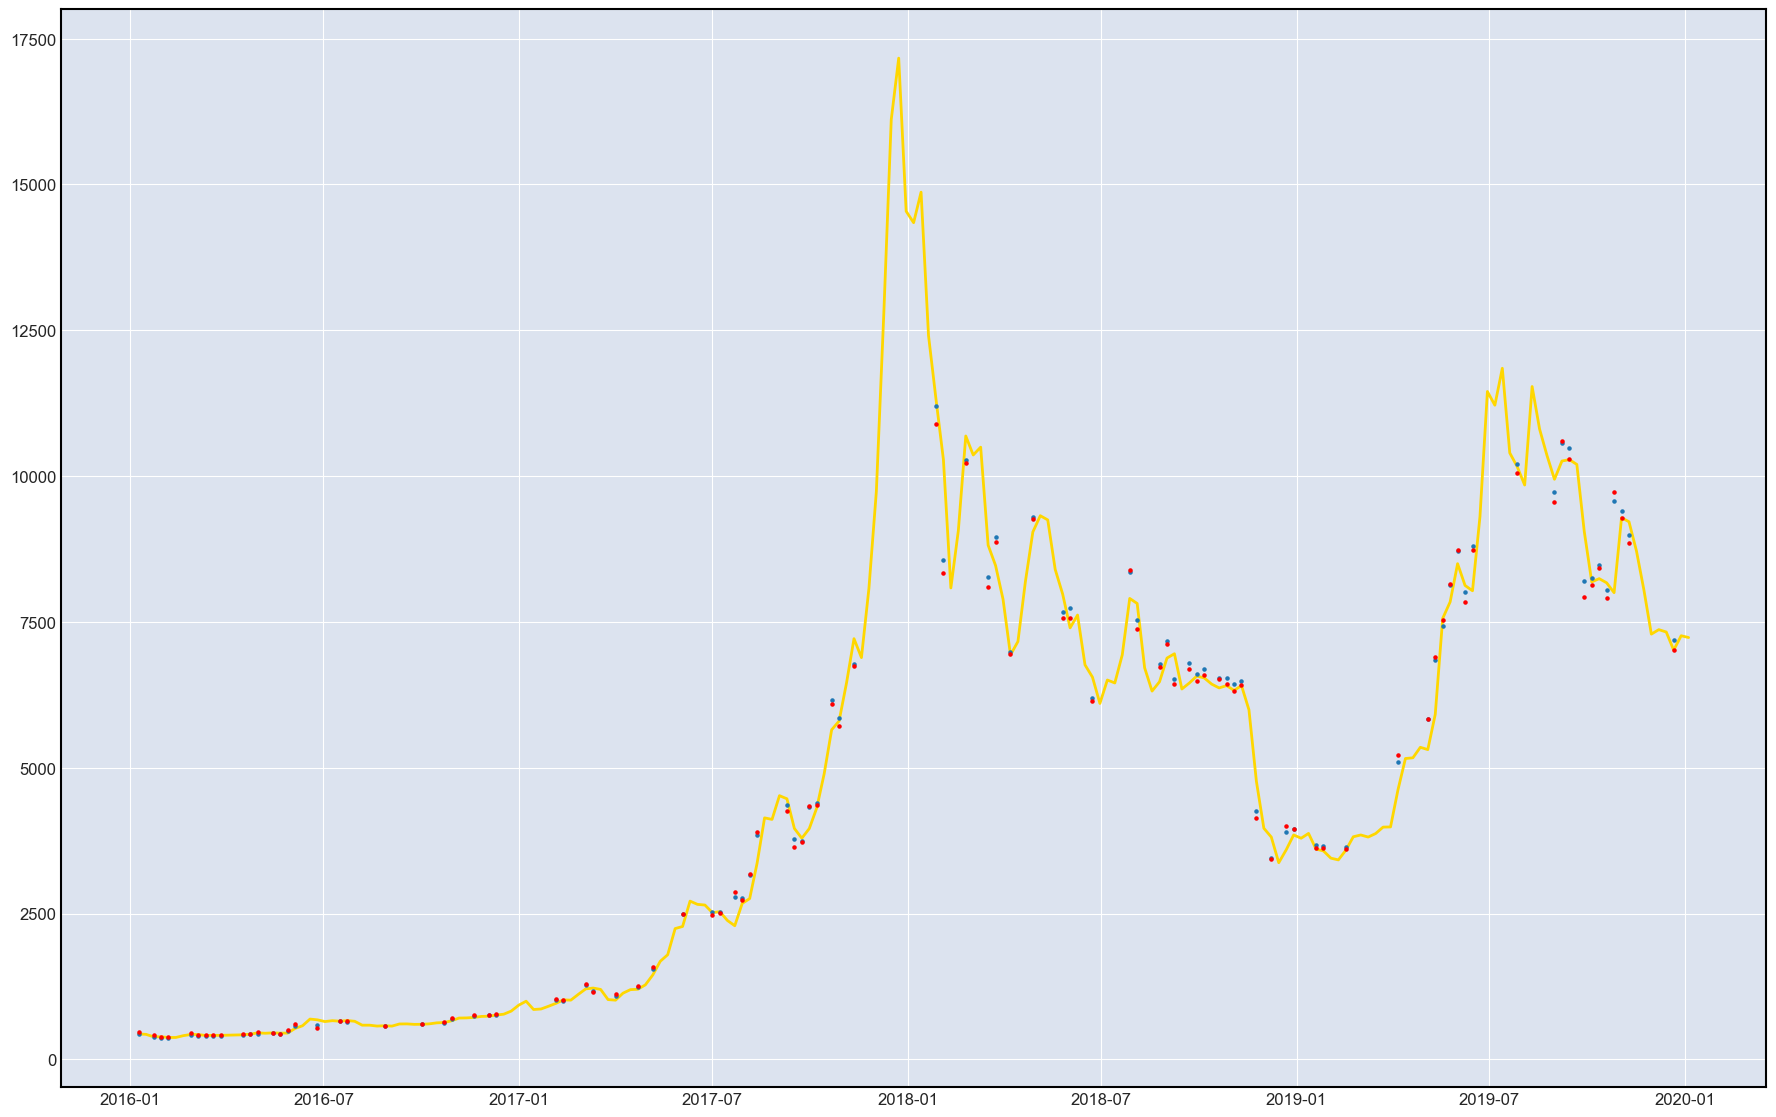

In [54]:
maskData = (week.index > '2016') & (week.index < '2020')
maskPrediction = (xTest.index > '2016') & (xTest.index < '2020')
maskPrediction2 = (xTest2.index > '2016') & (xTest2.index < '2020')

plt.figure(figsize=(22,14))
plt.plot(week[maskData].index + pd.DateOffset(days=7) ,week[maskData].Weighted_Price, color='gold')
plt.scatter(xTest[maskPrediction].index, regr.predict(xTest[maskPrediction]), s=5, zorder=3)
#plt.scatter(xTest2[maskPrediction2].index, regr2.predict(xTest2[maskPrediction2]), s=5, zorder=4, color='red')
plt.scatter(xTest[maskPrediction].index, regr2.predict(xTest[maskPrediction]), s=5, zorder=4, color='red')
# regrAvg = (regr2.predict(xTest[maskPrediction]) + regr.predict(xTest[maskPrediction]))/2
# plt.scatter(xTest[maskPrediction].index, regrAvg, s=5, zorder=4, color='lime')

## P-values

In [55]:
xAndConst = sm.add_constant(xTrain2)
model = sm.OLS(yTrain2, xAndConst)
results = model.fit()
pandaPvalues = pd.DataFrame({'coef':results.params, 'p-values':round(results.pvalues,4)})

print('Bic :', results.bic)
print('RMSE :', np.sqrt(results.mse_resid))
print('Rsquared : ', results.rsquared)
pandaPvalues.sort_values(by='p-values')

Bic : 4144.792903981974
RMSE : 299.9609510305068
Rsquared :  0.9973131313103146


,coef,p-values
Open,-0.342468,0.0000
Low,0.238664,0.0000
Close,0.881727,0.0000
High,0.225292,0.0007
Volume_(BTC),0.000309,0.3324
const,-4.813283,0.8821


In [56]:
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(weekFeatures.drop(['Volume_(BTC)'], axis=1),
                                                    weekPrice, test_size=.4, random_state=2240)
regr2 =  LinearRegression(fit_intercept=False).fit(xTrain2,yTrain2)
print('R² Training Data: ', regr2.score(xTrain2,yTrain2))
print('R² Test Data: ', regr2.score(xTest2,yTest2))

R² Training Data:  0.9972972064468052
R² Test Data:  0.9932566038203634


In [57]:
model = sm.OLS(yTrain2, xTrain2)
results = model.fit()
pandaPvalues = pd.DataFrame({'coef':results.params, 'p-values':round(results.pvalues,4)})

print('Bic :', results.bic)
print('RMSE :', np.sqrt(results.mse_resid))
pandaPvalues.sort_values(by='p-values')

Bic : 4135.167875229991
RMSE : 299.79109303059084


,coef,p-values
Open,-0.343717,0.0000
Low,0.236833,0.0000
Close,0.872650,0.0000
High,0.237747,0.0003


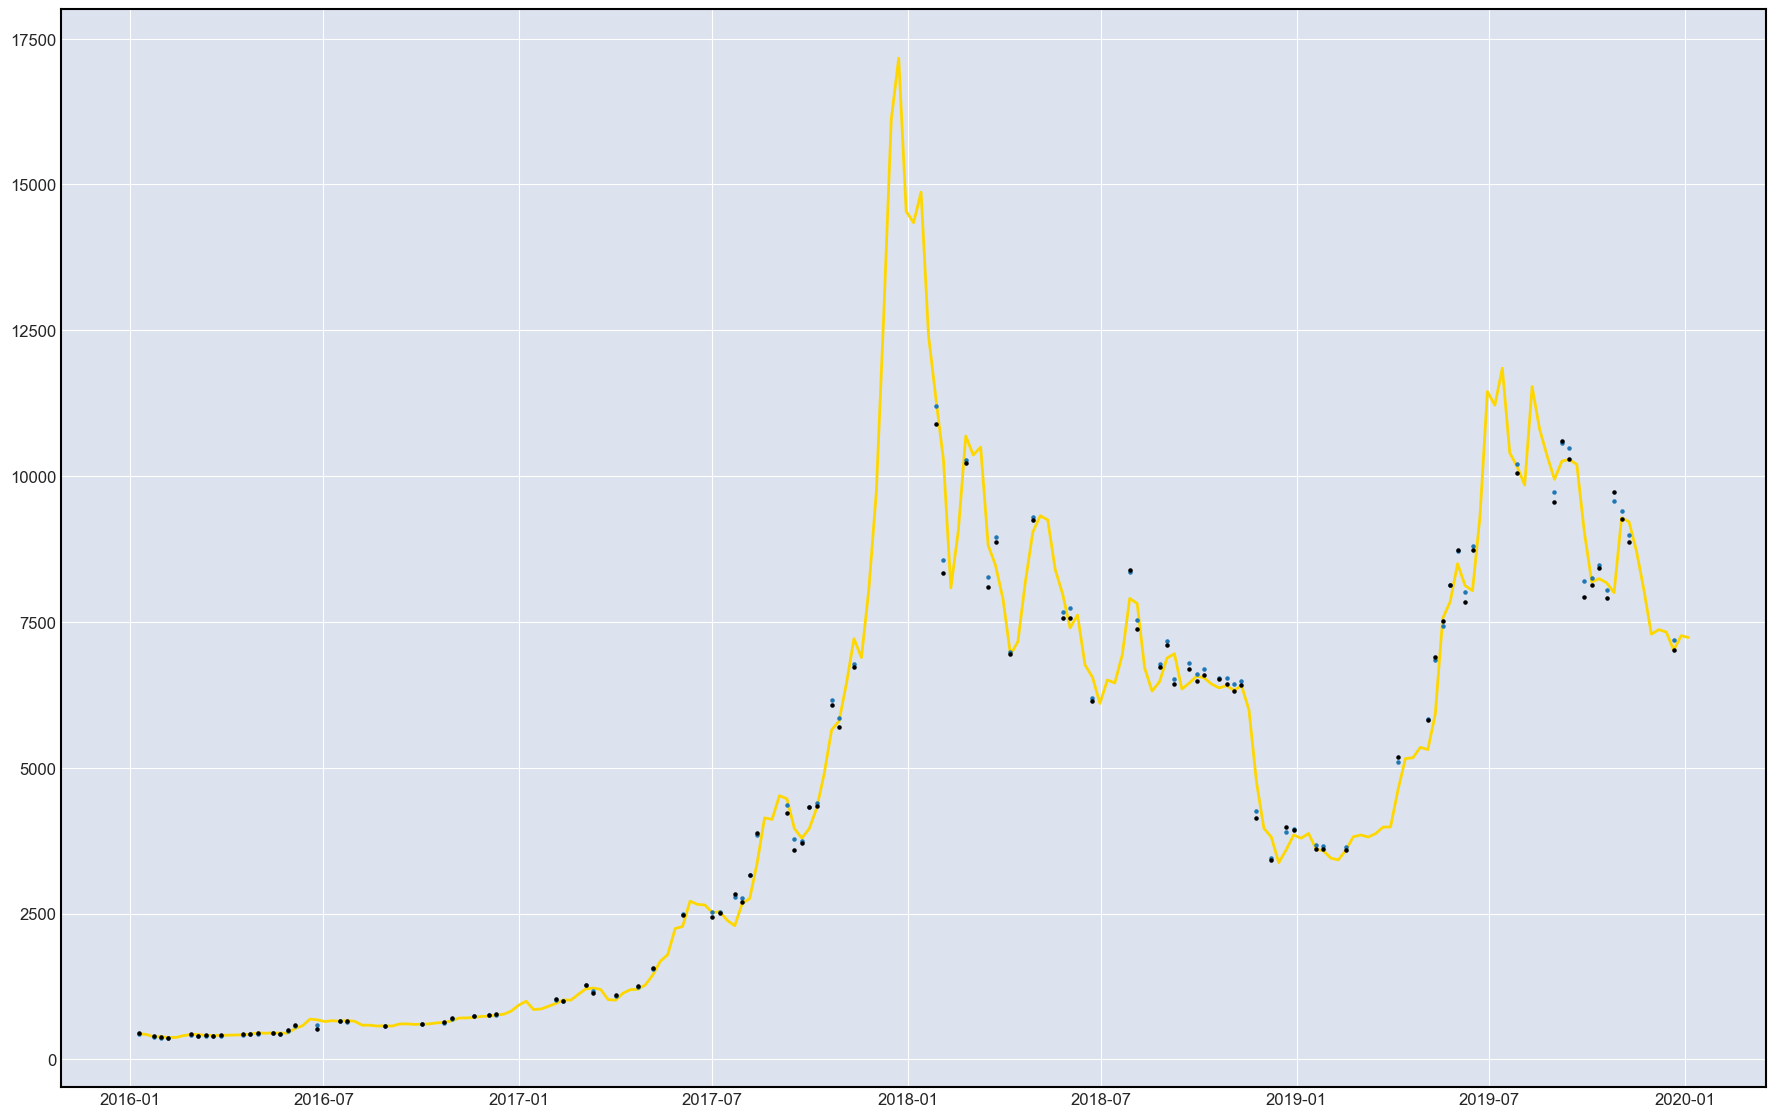

In [58]:
maskData = (week.index > '2016') & (week.index < '2020')
maskPrediction = (xTest.index > '2016') & (xTest.index < '2020')
maskPrediction2 = (xTest2.index > '2016') & (xTest2.index < '2020')

redcuedXtest = xTest.drop(['Volume_(BTC)'], axis=1)

plt.figure(figsize=(22,14))
plt.plot(week[maskData].index + pd.DateOffset(days=7) ,week[maskData].Weighted_Price, color='gold')
plt.scatter(xTest[maskPrediction].index, regr.predict(xTest[maskPrediction]), s=5, zorder=3)
plt.scatter(redcuedXtest[maskPrediction].index, regr2.predict(redcuedXtest[maskPrediction]), s=5, zorder=4, color='black')

# Alternative approach to weekly predictions
### Predicting weekly prices using entire week candlesticks

In [59]:
newDayData = dayData.copy(deep=True) 
#newDayData.head(10)

In [60]:
week.head(3)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,6.90,4.39,6.00,459.922995,2469.760890,5.805208
2012-01-07 07:52:00,6.80,7.38,6.23,6.40,383.685872,2660.671239,6.851910
2012-01-14 07:52:00,6.30,7.15,5.52,6.95,590.087191,3736.598157,6.356851


In [61]:
# for i in range(newDayData.shape[0]):
#     if i%7 == 0 :
#         newDayData['Weighted_Price'][i] = week['Weighted_Price'][i//7]
#     else :
#         newDayData['Weighted_Price'][i] = np.nan
# newDayData = newDayData.interpolate()

In [62]:
for i in range(newDayData.shape[0]):
    newDayData['Weighted_Price'][i] = week['Weighted_Price'][i//7]

In [63]:
#newDayData = newDayData[newDayData.index > '2016']
newDayData

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.58,4.39,4.58,96.819878,4.321995e+02,5.805208
2012-01-01 07:52:00,4.84,5.00,4.84,5.00,20.100000,9.890000e+01,5.805208
2012-01-02 07:52:00,5.00,5.00,5.00,5.00,19.048000,9.524000e+01,5.805208
2012-01-03 07:52:00,5.32,5.32,4.93,4.93,100.037281,5.239652e+02,5.805208
2012-01-04 07:52:00,5.19,5.79,5.19,5.79,120.233260,6.529162e+02,5.805208
...,...,...,...,...,...,...,...
2021-03-26 07:52:00,53415.39,55597.04,52489.10,54915.21,4340.604099,2.338751e+08,55276.183860
2021-03-27 07:52:00,54968.90,56686.15,53948.35,56203.95,2366.879294,1.314790e+08,56715.932479
2021-03-28 07:52:00,56188.29,56573.04,54677.51,56020.88,2507.439479,1.392435e+08,56715.932479


In [64]:
price = newDayData['Weighted_Price']
newPrice = price.tail(price.shape[0]-1)
newFeatures = pd.DataFrame(data=newDayData.head(newDayData.shape[0]-1), columns=feat) 
newFeatures.index = newFeatures.index + pd.DateOffset(days=1)
# newFeatures, newPrice

In [65]:
"""
{'bic': [29441.003959326663, 3074],
 'mse': [117492.73643335747, 3074],
 'rsq': [0.9981292202370502, 511],
 'avgRsq': [0.9972494799386351, 511]}
 """
#bestRandomState(0,5000,newFeatures, newPrice)

"\n{'bic': [29441.003959326663, 3074],\n 'mse': [117492.73643335747, 3074],\n 'rsq': [0.9981292202370502, 511],\n 'avgRsq': [0.9972494799386351, 511]}\n "

In [66]:
xTrain, xTest, yTrain, yTest = train_test_split(newFeatures, newPrice, test_size=.4, random_state=511)
regr =  LinearRegression().fit(xTrain,yTrain)
print('R² Training Data: ', regr.score(xTrain,yTrain))
print('R² Test Data: ', regr.score(xTest,yTest))

R² Training Data:  0.99636973964022
R² Test Data:  0.9981292202370502


In [67]:
resampledXtest = xTest.resample('7D', origin='start').agg({'Open': 'first', 'High': 'max','Low': 'min',
     'Close': 'last', 'Volume_(BTC)': 'sum'})
resampledYtest = yTest.resample('7D', origin='start').agg({'Weighted_Price': 'mean'})
resampledXtest = resampledXtest.interpolate()
regr.predict(resampledXtest).shape

(483,)

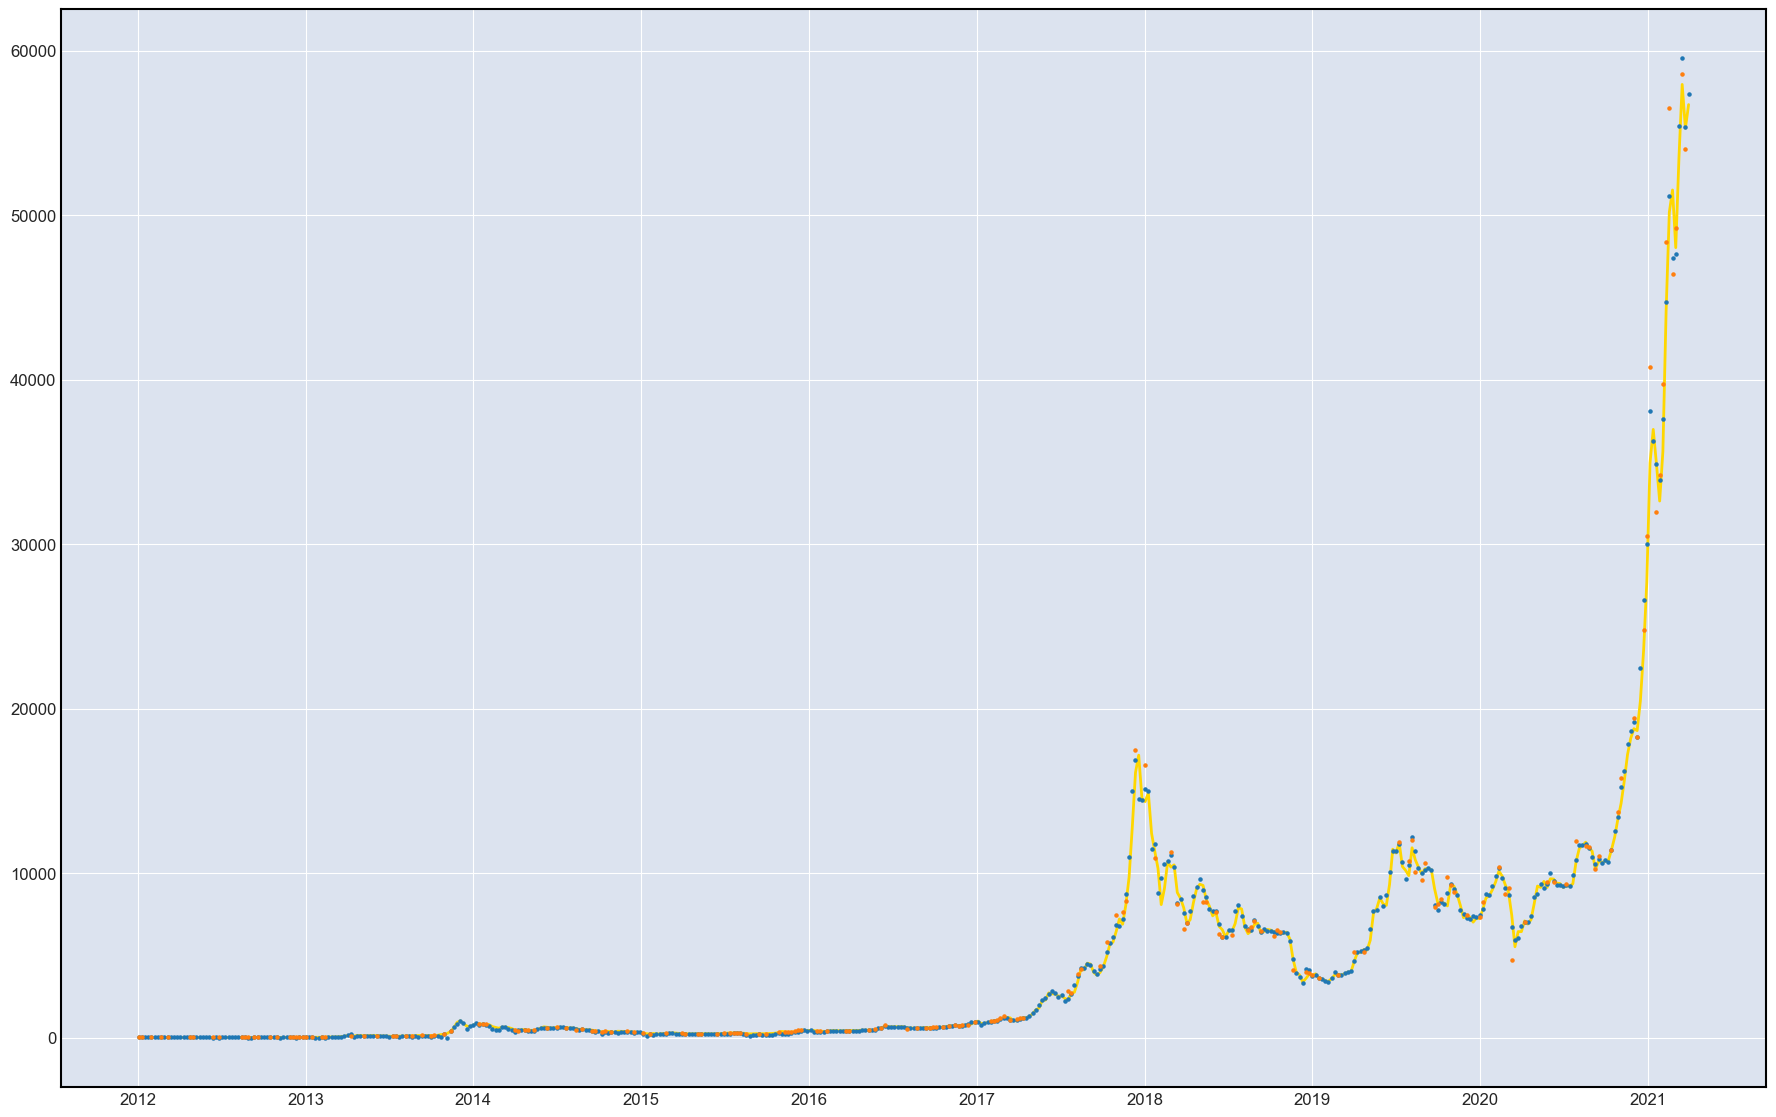

In [68]:
plt.figure(figsize=(22,14))
plt.plot(week.index + pd.DateOffset(days=3),week.Weighted_Price, color='gold')
plt.scatter(resampledXtest.index, regr.predict(resampledXtest), s=5 , zorder=3)
plt.scatter(xTest2.index - pd.DateOffset(days=4), regr2.predict(xTest2), s=5 , zorder=3)

# Studying monthly patterns (timeframe = 1 month)

In [69]:
from scipy.optimize import curve_fit

In [70]:
monthData = resampledData(bitcoinData[bitcoinData.index>'2012'],'1M')
newMonthData = monthData.copy(deep=True) 
newMonthData.index = list(range(newMonthData.shape[0]))

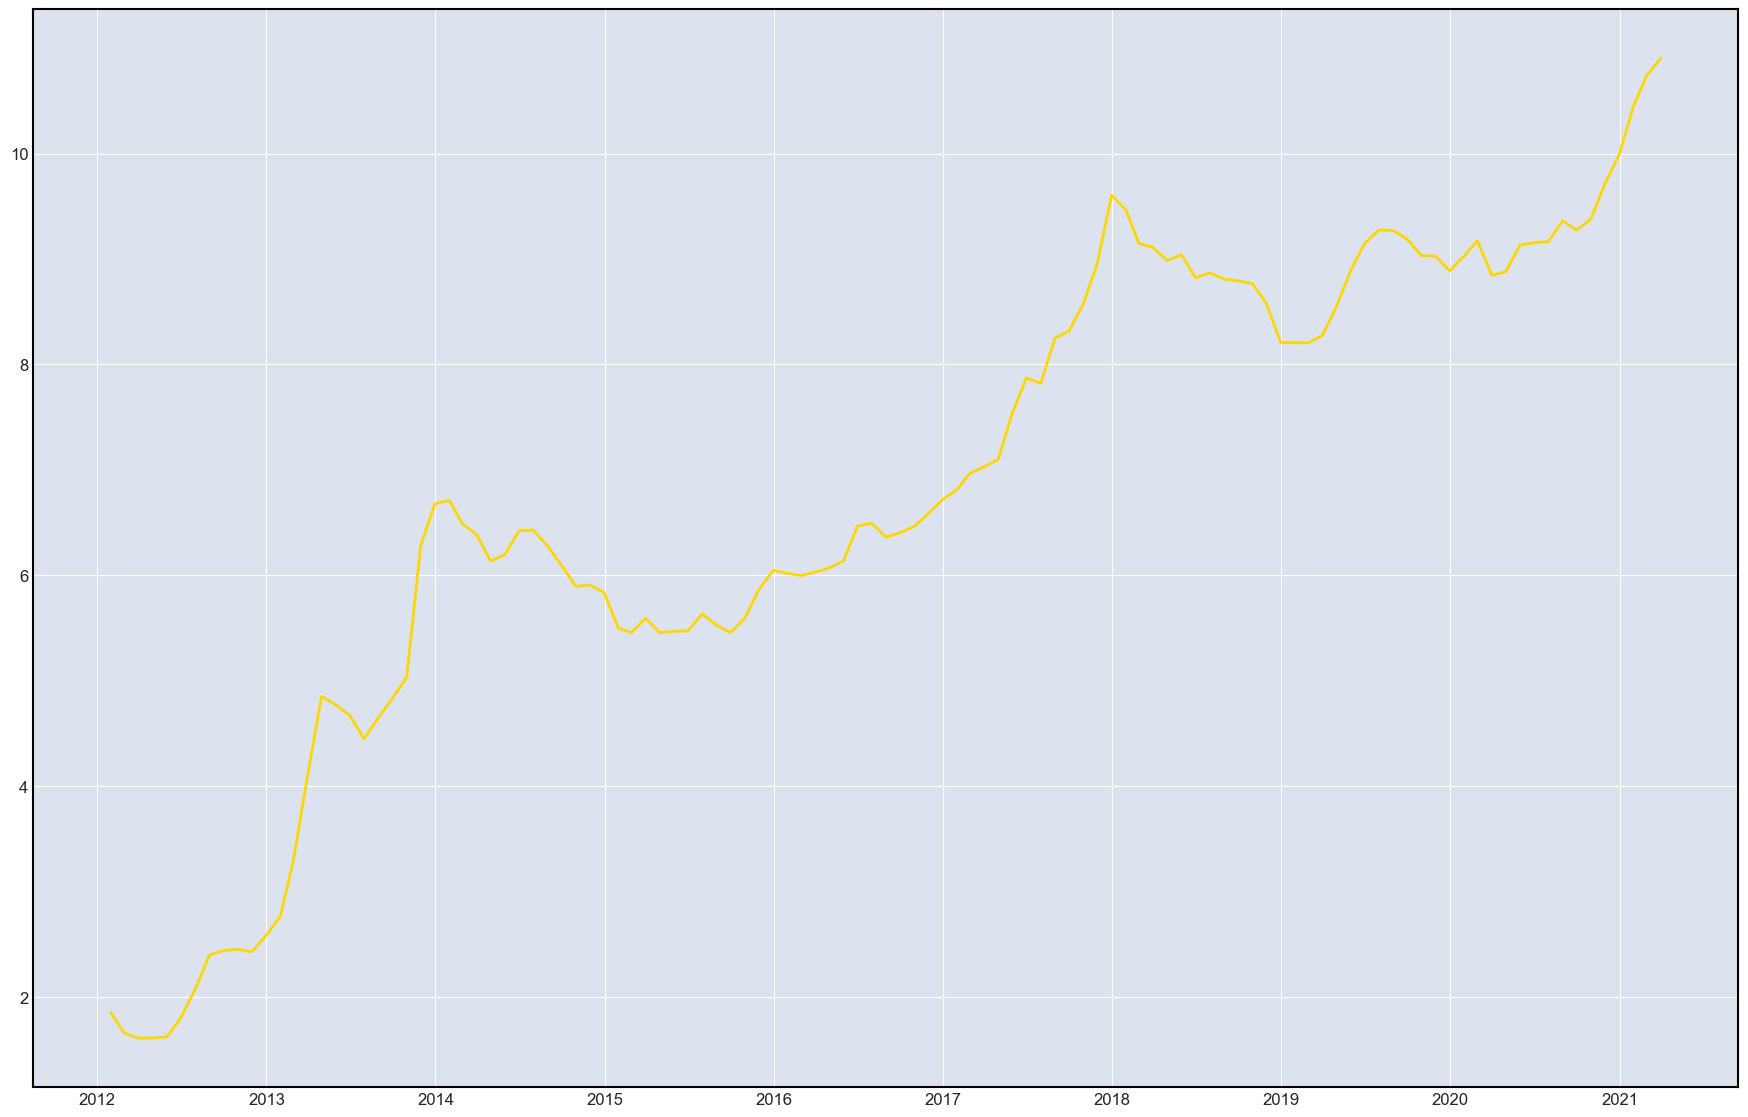

In [71]:
plt.figure(figsize=(22,14))
plt.plot(monthData.index,np.log(monthData.Weighted_Price), color='gold')

In [72]:
def sigmoid(x,a,b) : return 1 / (1 + np.exp(-a*(x-b)))

In [73]:
#def func(x,a,b,c,d) : return a*(np.log(x+b) + c*np.sin(d*x+b))
def func(x,a,b,c,d) : return a*(np.log(x+d+1) + np.sin(b*(x+d)))

In [74]:
def func2(x,a,b,c,d) : return a*(np.log(x+1+d)-abs(np.sin(b*(x+d))))+x/c

In [75]:
def func3(x,a,b,c,d,n) : return a*(np.log(x+1+d)-abs(np.sin(b*(x**(np.log(x+1)**n)+d))))+x/c

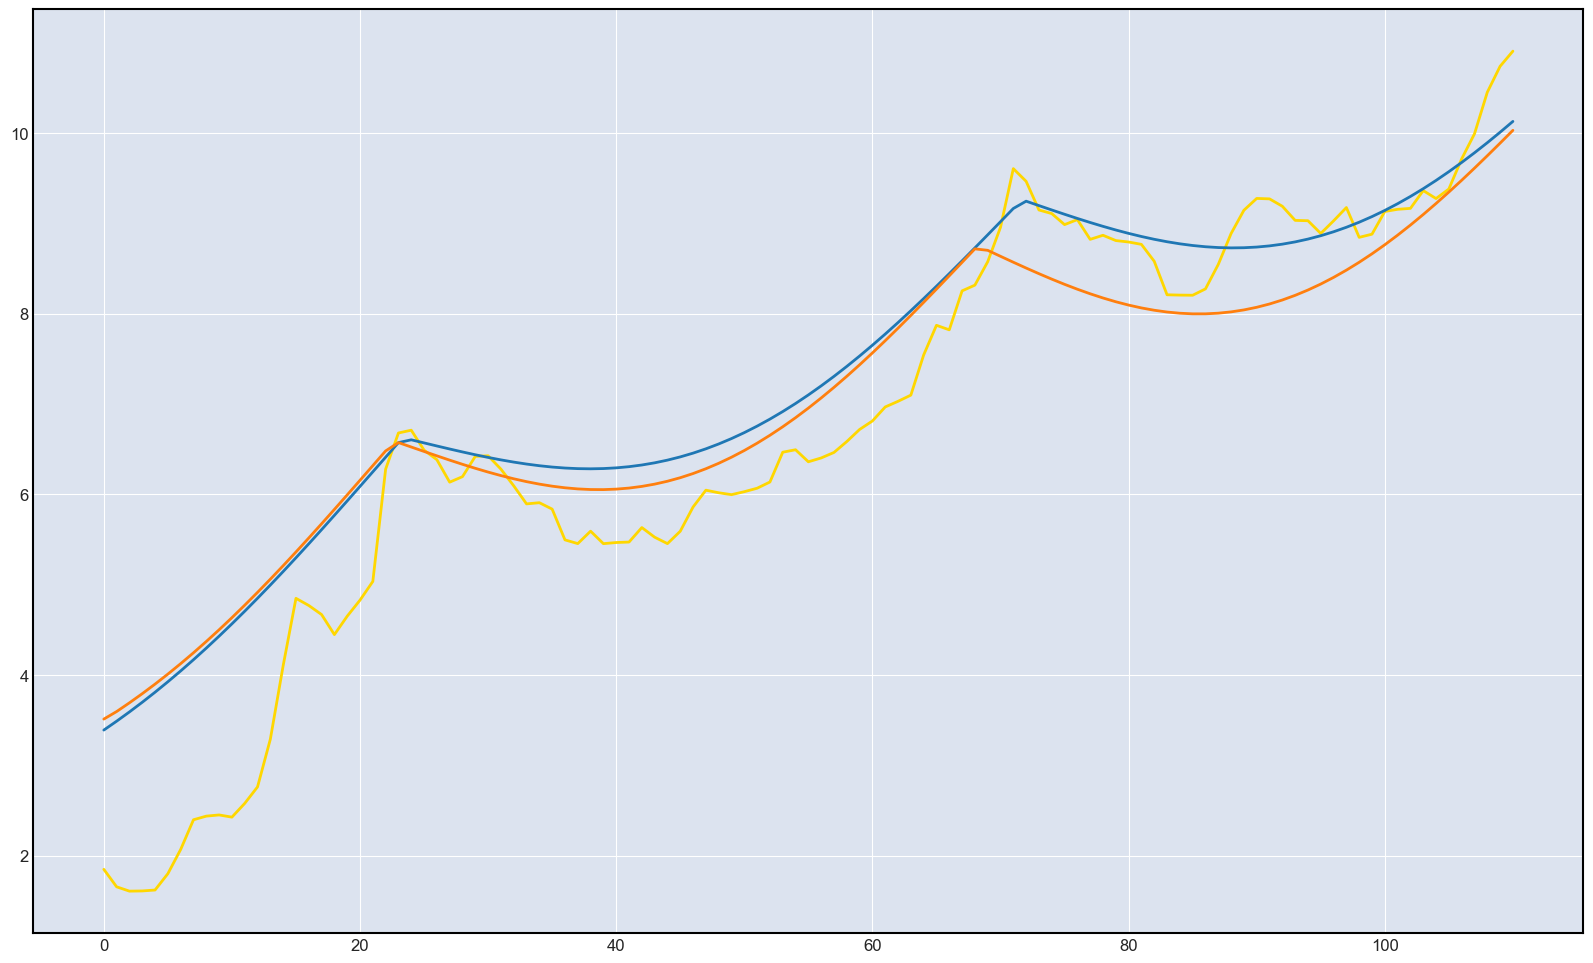

In [76]:
x = np.array(newMonthData.index)
y = np.array(newMonthData.Weighted_Price)
g = 1.5,0.065,30,25
g2 = 1.55,0.065,40,25,0.008
logY = func2(x,*g)
logY2 = func3(x,*g2)

plt.figure(figsize=(20,12))
plt.plot(x,np.log(y),color='gold')
plt.plot(x,logY)
plt.plot(x,logY2)

In [77]:
coef, cov = curve_fit(func2, x, np.log(y), g)
coef

array([ 1.21201597,  0.07103549, 21.42195358, 16.50647362])

In [78]:
coef2, cov2 = curve_fit(func3, x, np.log(y), g2)
coef2

C:\Users\feres\AppData\Local\Temp\ipykernel_14264\1915595682.py:1: RuntimeWarning:

divide by zero encountered in power



array([ 1.46299426,  0.14297595, 26.6145094 ,  4.45210064, -0.10337211])

C:\Users\feres\AppData\Local\Temp\ipykernel_14264\1915595682.py:1: RuntimeWarning:

divide by zero encountered in power



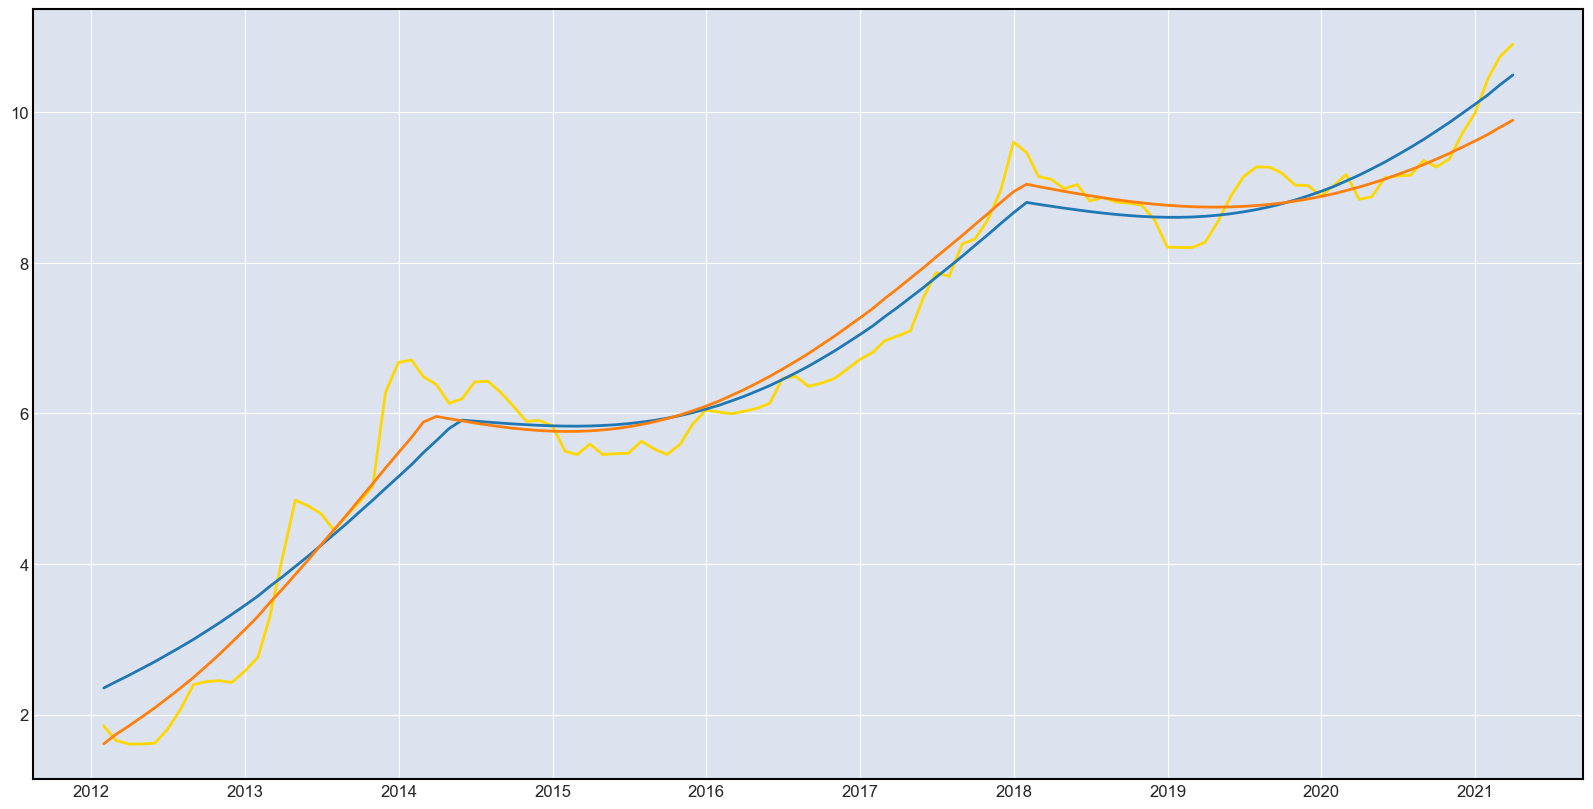

In [79]:
plt.figure(figsize=(20,10))
#plt.scatter(x,/max(newMonthData.Weighted_Price))
plt.plot(monthData.index,np.log(y), color='gold')
plt.plot(monthData.index,func2(x,*coef))
plt.plot(monthData.index,func3(x,*coef2))

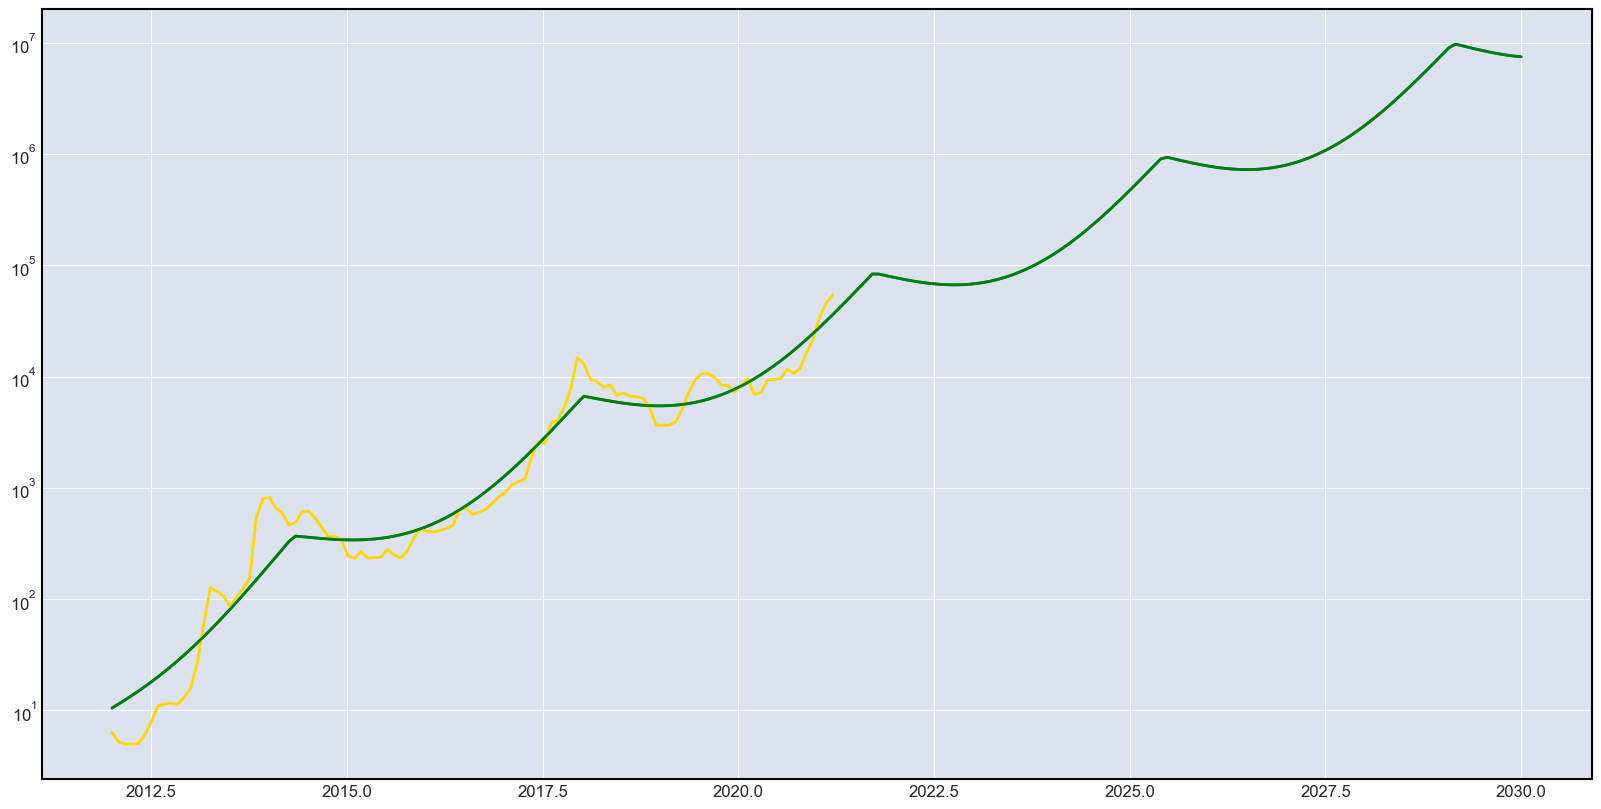

In [80]:
index = np.linspace(2012,2030,(2030-2012)*12)
plt.figure(figsize=(20,10))
predX = np.array((range((2030-2012)*12)))

plt.semilogy(index,np.exp(func2(predX,*coef)))
plt.plot(index[:y.shape[0]],y,color='gold')
plt.plot(index,np.exp(func2(predX,*coef)), color='green')

In [81]:
def logFunc(x,a,b) : return a*np.log(x+1) + b*x

In [82]:
g3 = 1.5,.02
# plt.figure(figsize=(7,5))
# plt.plot(x,np.log(y))
# plt.plot(x,logFunc(x,*g3))

In [83]:
coef3, cov3 = curve_fit(logFunc,x,np.log(y),g3)
coef3

array([1.26673019, 0.03632303])

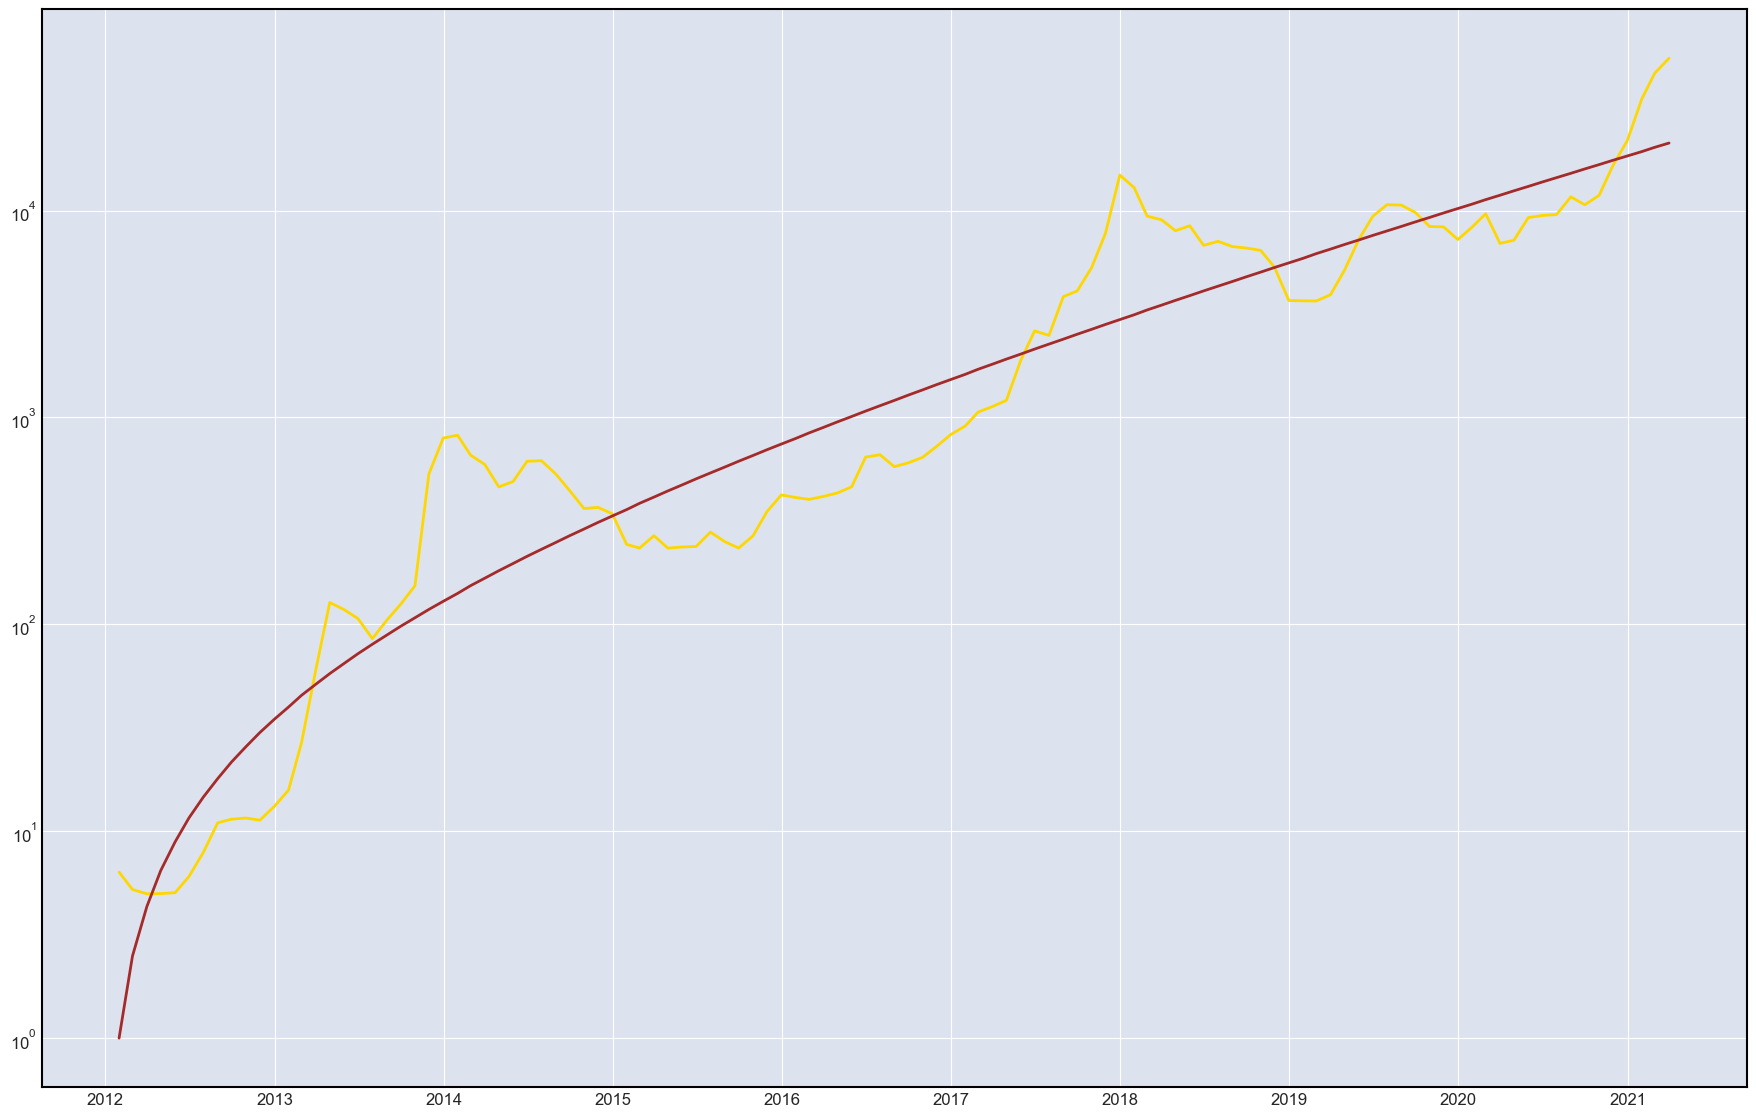

In [84]:
plt.figure(figsize=(22,14))
plt.semilogy(monthData.index,monthData.Weighted_Price,color='gold')
plt.plot(monthData.index,np.exp(logFunc(x,*coef3)), color='brown')

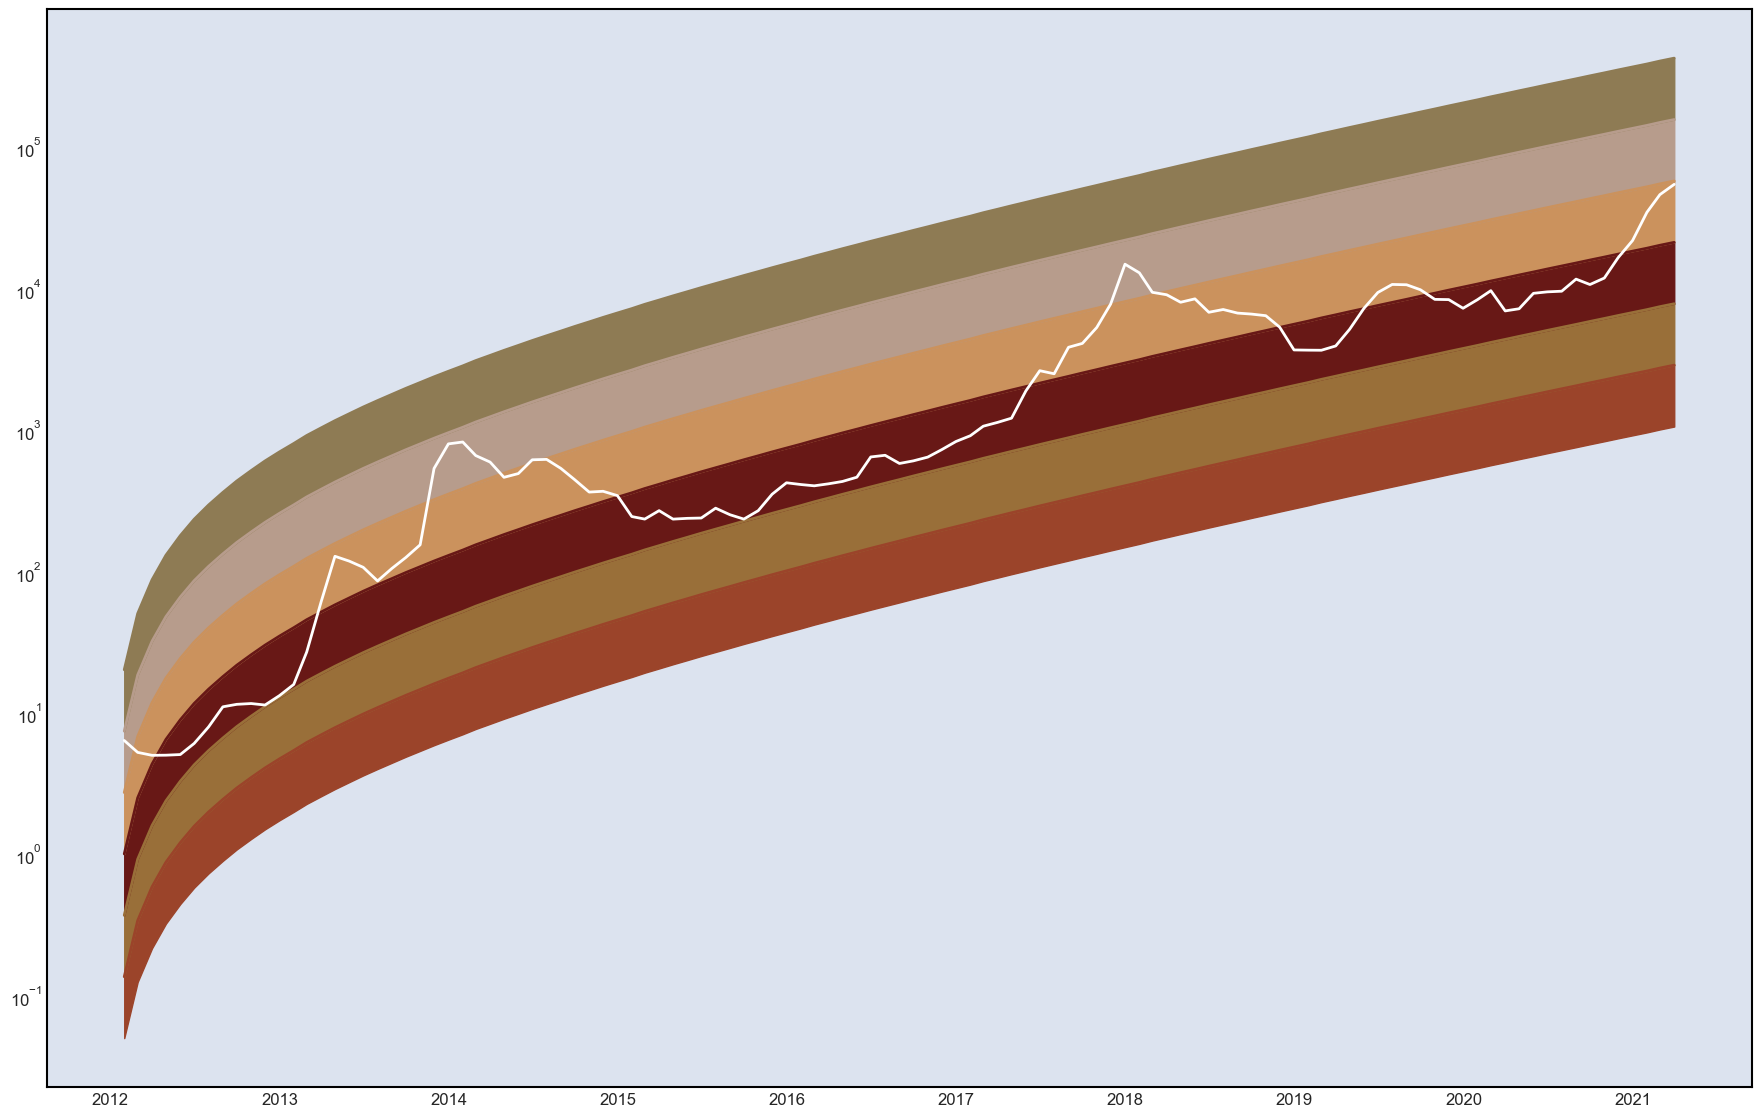

In [85]:
#plt.style.use("dark_background")

plt.figure(figsize=(22,14))
plt.grid(b=None)

plt.semilogy(monthData.index,monthData.Weighted_Price,color='white',zorder=3)
colors=['#9b442a','#996f39','#681816','#cb925d','#b79c8c','#8e7b54']
for i in range(-2,4) :
    plt.plot(monthData.index,np.exp(logFunc(x,*coef3)+i),color=colors[i+2])
    plt.fill_between(monthData.index, np.exp(logFunc(x,*coef3)+i-1), np.exp(logFunc(x,*coef3)+i),color=colors[i+2])

### 